In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import os
import joblib
from scipy.stats import pointbiserialr

# For data preprocessing and feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# For handling imbalanced data
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

# Create output directories
os.makedirs('visualizations', exist_ok=True)
print("Environment setup complete!")

Environment setup complete!


In [5]:
# Load the dataset
df = pd.read_csv('weather_data.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Check column data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
display(df.describe())

# Check target variable distribution
print("\nTarget variable distribution:")
target_counts = df['rain_or_not'].value_counts()
print(target_counts)
print(f"Percentage of rainy days: {target_counts['Rain'] / len(df) * 100:.2f}%")

Dataset shape: (311, 7)

First 5 rows:


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331



Data types:
date                object
avg_temperature    float64
humidity           float64
avg_wind_speed     float64
rain_or_not         object
cloud_cover        float64
pressure           float64
dtype: object

Missing values per column:
date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64

Summary statistics:


,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure
count,296.000000,296.000000,296.000000,296.000000,311.000000
mean,25.983840,55.041385,7.556636,49.834827,1001.059119
std,6.802475,19.220133,5.344683,29.009459,28.835595
min,15.000000,30.000000,0.069480,0.321826,951.240404
25%,20.265692,34.280826,3.550354,24.530951,975.757545
50%,27.177958,56.759806,7.326421,50.725120,1001.938586
75%,32.204599,72.189837,11.050627,76.046506,1026.578884
max,35.000000,90.000000,56.636041,99.834751,1049.543752



Target variable distribution:
rain_or_not
Rain       198
No Rain    113
Name: count, dtype: int64
Percentage of rainy days: 63.67%


In [7]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Examine rows with missing values
missing_mask = df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']].isnull().any(axis=1)
print(f"Number of rows with missing values: {missing_mask.sum()}")
print("\nSample of rows with missing values:")
display(df[missing_mask].head())

# Check if missing values have any pattern with respect to the target variable
if missing_mask.sum() > 0:
    missing_rain_counts = df[missing_mask]['rain_or_not'].value_counts(normalize=True) * 100
    overall_rain_counts = df['rain_or_not'].value_counts(normalize=True) * 100
    
    print("\nRain distribution in rows with missing values:")
    print(missing_rain_counts)
    print("\nOverall rain distribution:")
    print(overall_rain_counts)

# Create a copy for preprocessing
df_clean = df.copy()

# Handle missing values with conditional imputation based on rain status
for feature in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']:
    if df_clean[feature].isnull().sum() > 0:
        # Calculate mean values for each rain status
        rain_mean = df_clean[df_clean['rain_or_not'] == 'Rain'][feature].mean()
        no_rain_mean = df_clean[df_clean['rain_or_not'] == 'No Rain'][feature].mean()
        
        # Impute based on rain status
        df_clean.loc[(df_clean[feature].isnull()) & (df_clean['rain_or_not'] == 'Rain'), feature] = rain_mean
        df_clean.loc[(df_clean[feature].isnull()) & (df_clean['rain_or_not'] == 'No Rain'), feature] = no_rain_mean
        
        print(f"Imputed {feature} - Rain mean: {rain_mean:.2f}, No Rain mean: {no_rain_mean:.2f}")

# Convert target variable to binary
df_clean['rain_binary'] = df_clean['rain_or_not'].map({'Rain': 1, 'No Rain': 0})

# Check for remaining missing values
print("\nMissing values after imputation:")
print(df_clean.isnull().sum())

# Display the first few rows after preprocessing
print("\nFirst 5 rows after preprocessing:")
display(df_clean.head())

Number of rows with missing values: 15

Sample of rows with missing values:


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
12,2023-01-13,NaN,NaN,NaN,No Rain,NaN,1022.950823
15,2023-01-16,NaN,NaN,NaN,Rain,NaN,1011.022515
16,2023-01-17,NaN,NaN,NaN,No Rain,NaN,963.535408
44,2023-02-14,NaN,NaN,NaN,Rain,NaN,1006.016818
47,2023-02-17,NaN,NaN,NaN,Rain,NaN,991.879332



Rain distribution in rows with missing values:
rain_or_not
Rain       60.0
No Rain    40.0
Name: proportion, dtype: float64

Overall rain distribution:
rain_or_not
Rain       63.665595
No Rain    36.334405
Name: proportion, dtype: float64
Imputed avg_temperature - Rain mean: 27.53, No Rain mean: 23.25
Imputed humidity - Rain mean: 59.81, No Rain mean: 46.62
Imputed avg_wind_speed - Rain mean: 8.07, No Rain mean: 6.64
Imputed cloud_cover - Rain mean: 49.07, No Rain mean: 51.18

Missing values after imputation:
date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
rain_binary        0
dtype: int64

First 5 rows after preprocessing:


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,rain_binary
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681,1
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025,1
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357,1
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142,1
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331,1


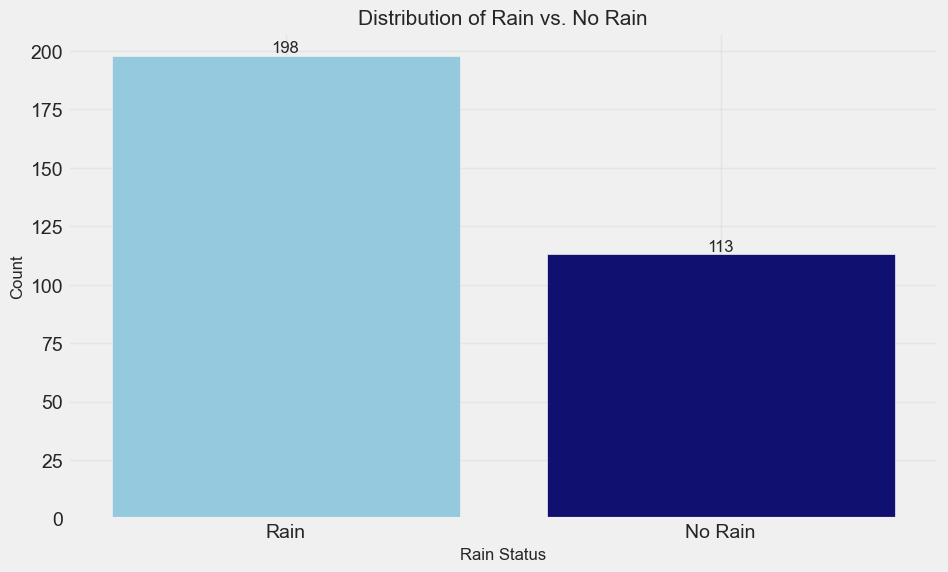

In [9]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='rain_or_not', data=df_clean, palette=['skyblue', 'navy'])
plt.title('Distribution of Rain vs. No Rain', fontsize=15)
plt.xlabel('Rain Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)

plt.grid(True, alpha=0.3)
plt.savefig('visualizations/rain_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

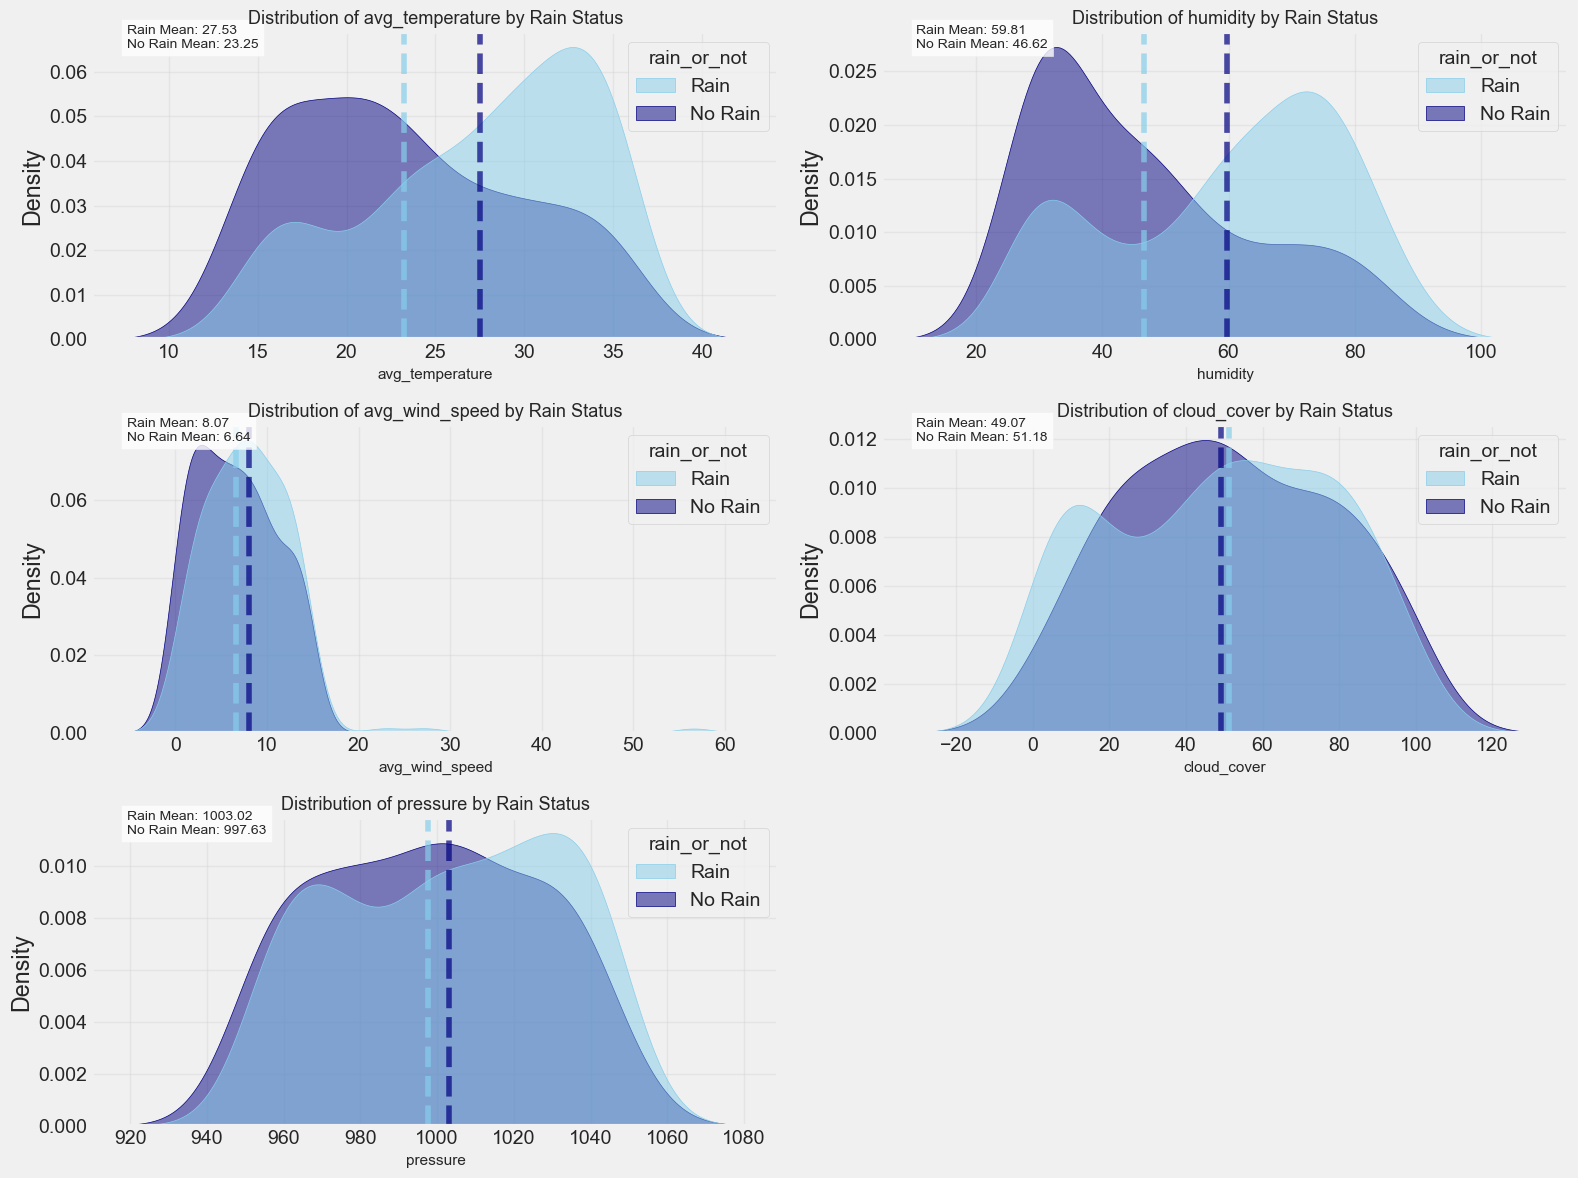

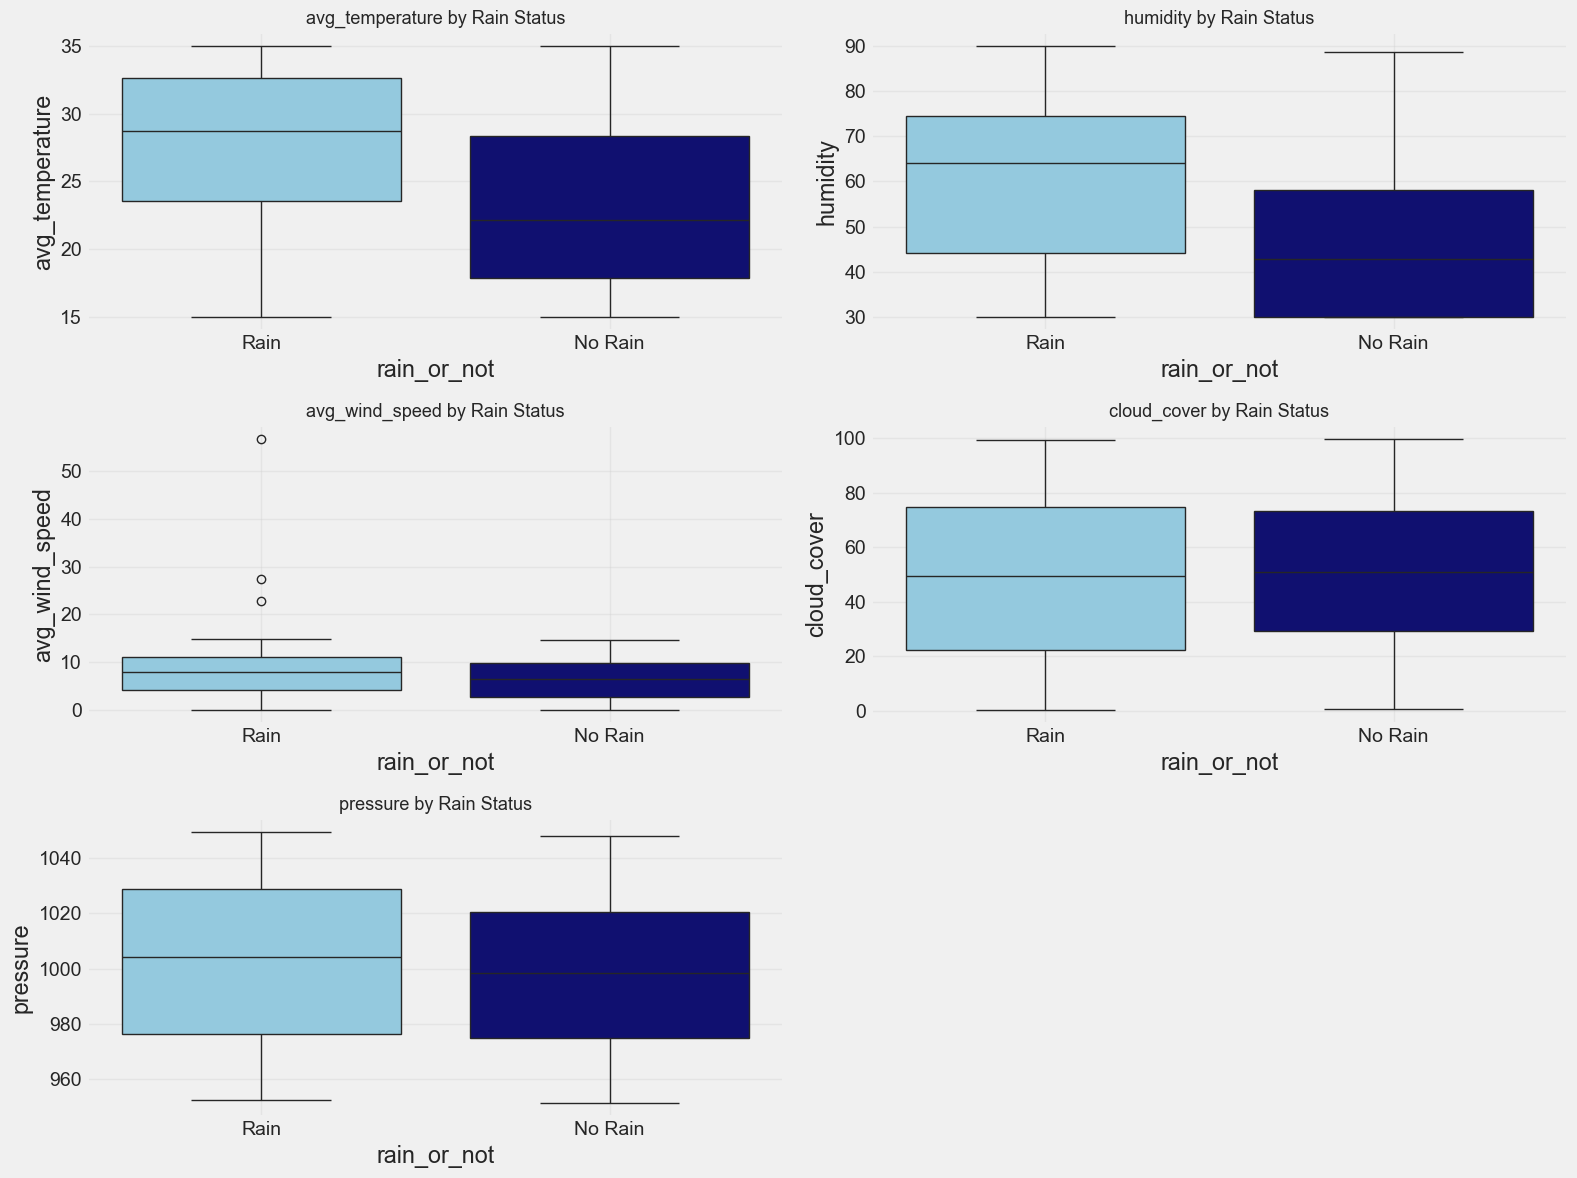

In [11]:
# Define features for analysis
features = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

# Plot distribution of each feature by rain status
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(data=df_clean, x=feature, hue='rain_or_not', common_norm=False, 
               palette=['skyblue', 'navy'], fill=True, alpha=0.5)
    plt.title(f'Distribution of {feature} by Rain Status', fontsize=13)
    plt.xlabel(feature, fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Calculate and display mean values for each group
    rain_mean = df_clean[df_clean['rain_or_not'] == 'Rain'][feature].mean()
    no_rain_mean = df_clean[df_clean['rain_or_not'] == 'No Rain'][feature].mean()
    plt.axvline(rain_mean, color='navy', linestyle='--', alpha=0.7)
    plt.axvline(no_rain_mean, color='skyblue', linestyle='--', alpha=0.7)
    plt.text(0.05, 0.95, f'Rain Mean: {rain_mean:.2f}\nNo Rain Mean: {no_rain_mean:.2f}', 
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('visualizations/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Box plots for each feature by rain status
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x='rain_or_not', y=feature, data=df_clean, palette=['skyblue', 'navy'])
    plt.title(f'{feature} by Rain Status', fontsize=13)
    plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.savefig('visualizations/feature_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

Correlations with Rain:
           Feature  Correlation with Rain
1         humidity               0.338001
0  avg_temperature               0.309829
2   avg_wind_speed               0.132361
4         pressure               0.090059
3      cloud_cover              -0.035929


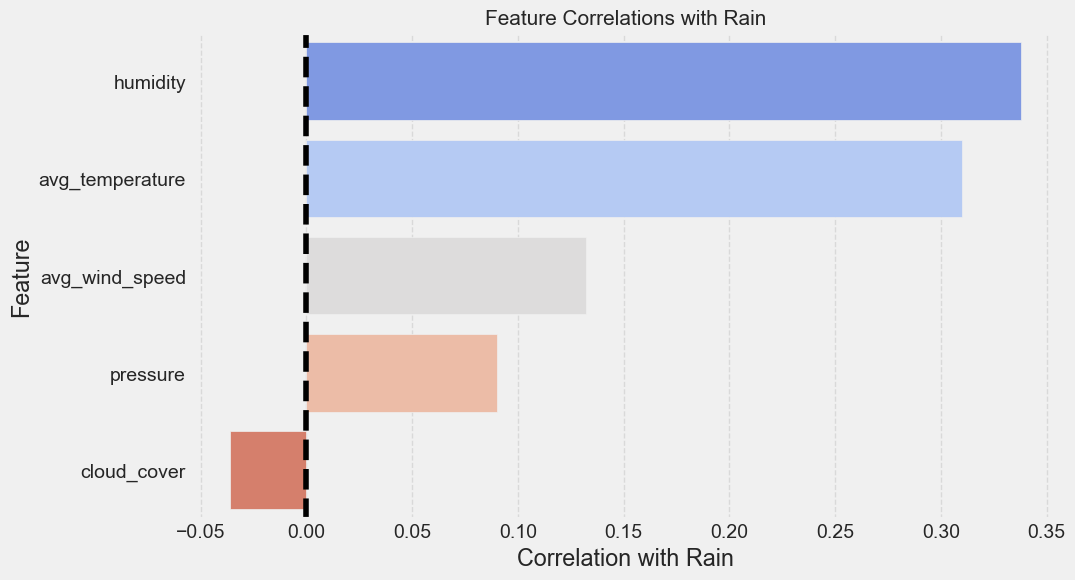

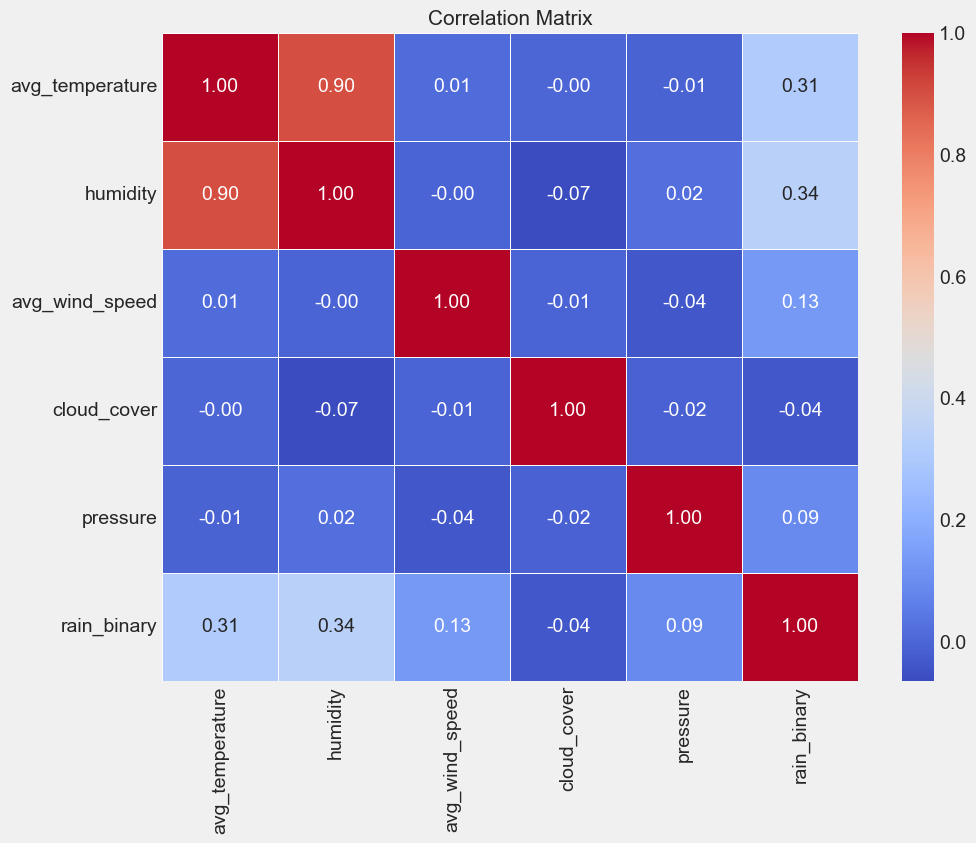

In [13]:
# Calculate correlations between features and rain_binary
correlations = {}
for feature in features:
    correlation = df_clean[feature].corr(df_clean['rain_binary'])
    correlations[feature] = correlation

# Create a dataframe for better visualization
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation with Rain'])
corr_df = corr_df.sort_values('Correlation with Rain', ascending=False)

print("Correlations with Rain:")
print(corr_df)

# Plot correlations
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation with Rain', y='Feature', data=corr_df, palette='coolwarm')
plt.title('Feature Correlations with Rain', fontsize=15)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig('visualizations/feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap for all numeric features
plt.figure(figsize=(10, 8))
numeric_columns = features + ['rain_binary']
correlation_matrix = df_clean[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix', fontsize=15)
plt.savefig('visualizations/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

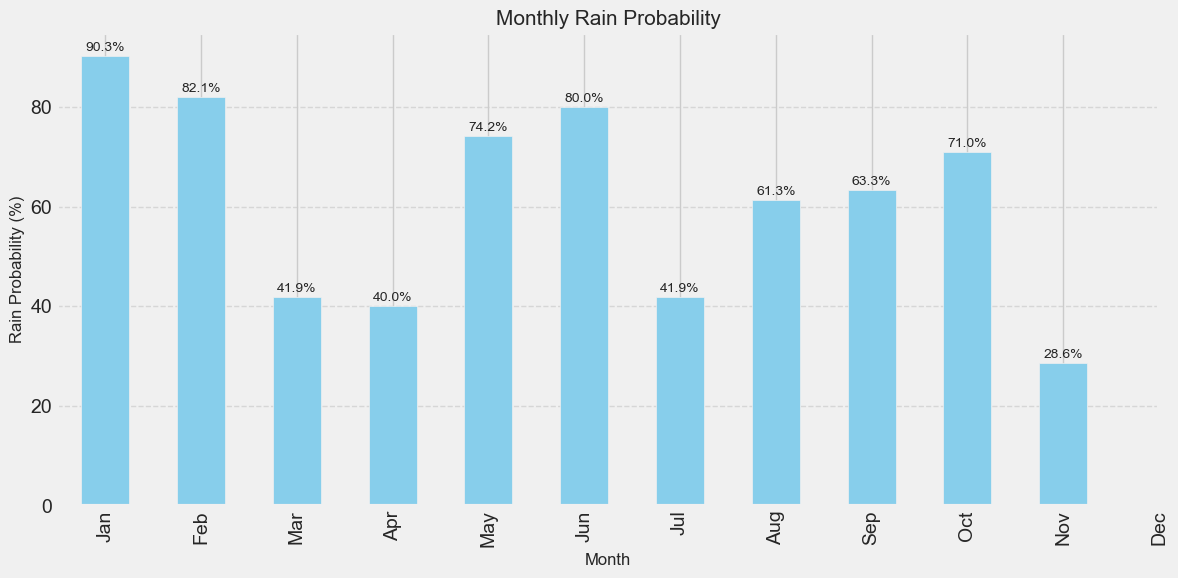

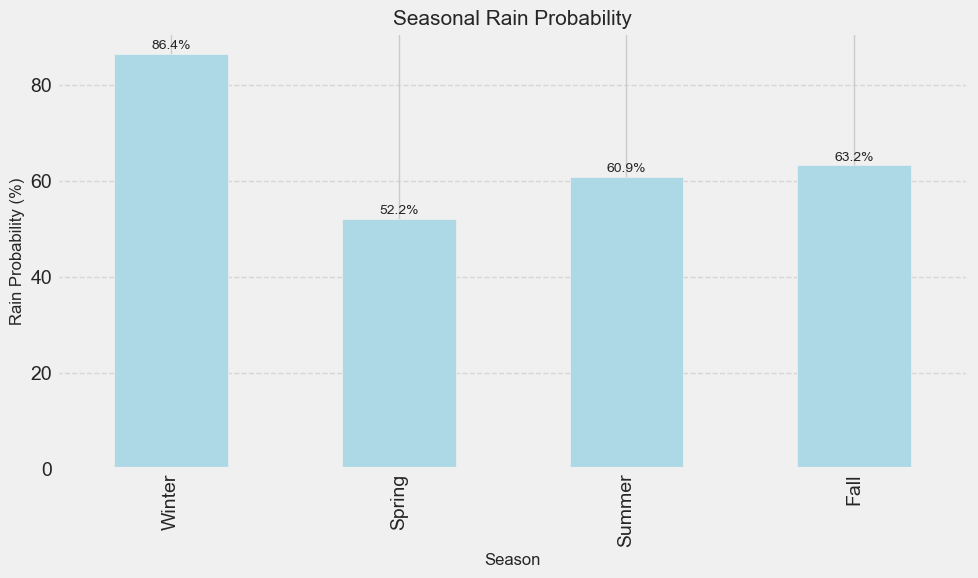

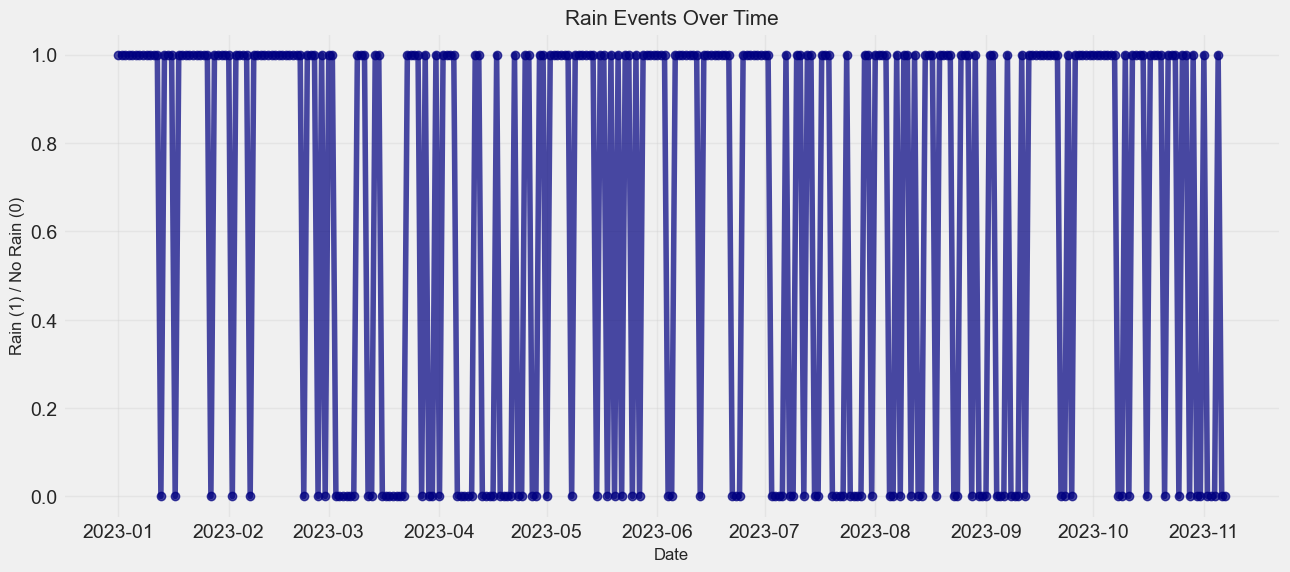

In [15]:
# Extract month from date
df_clean['month'] = df_clean['date'].dt.month

# Monthly rain distribution
monthly_rain = df_clean.groupby('month')['rain_binary'].mean() * 100
plt.figure(figsize=(12, 6))
ax = monthly_rain.plot(kind='bar', color='skyblue')
plt.title('Monthly Rain Probability', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Rain Probability (%)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add probability values on top of each bar
for i, v in enumerate(monthly_rain):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualizations/monthly_rain_probability.png', dpi=300, bbox_inches='tight')
plt.show()

# Create season feature
df_clean['season'] = df_clean['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                        'Spring' if x in [3, 4, 5] else
                                        'Summer' if x in [6, 7, 8] else 'Fall')

# Seasonal rain distribution
seasonal_rain = df_clean.groupby('season')['rain_binary'].mean() * 100
seasonal_rain = seasonal_rain.reindex(['Winter', 'Spring', 'Summer', 'Fall'])
plt.figure(figsize=(10, 6))
ax = seasonal_rain.plot(kind='bar', color='lightblue')
plt.title('Seasonal Rain Probability', fontsize=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Rain Probability (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add probability values on top of each bar
for i, v in enumerate(seasonal_rain):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualizations/seasonal_rain_probability.png', dpi=300, bbox_inches='tight')
plt.show()

# Time series of rain events
plt.figure(figsize=(14, 6))
df_sorted = df_clean.sort_values('date')
plt.plot(df_sorted['date'], df_sorted['rain_binary'], 'o-', alpha=0.7, color='navy')
plt.title('Rain Events Over Time', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rain (1) / No Rain (0)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('visualizations/rain_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

Maximum consecutive rain days: 14
Maximum consecutive no-rain days: 7
Average consecutive rain days: 3.36
Average consecutive no-rain days: 1.92


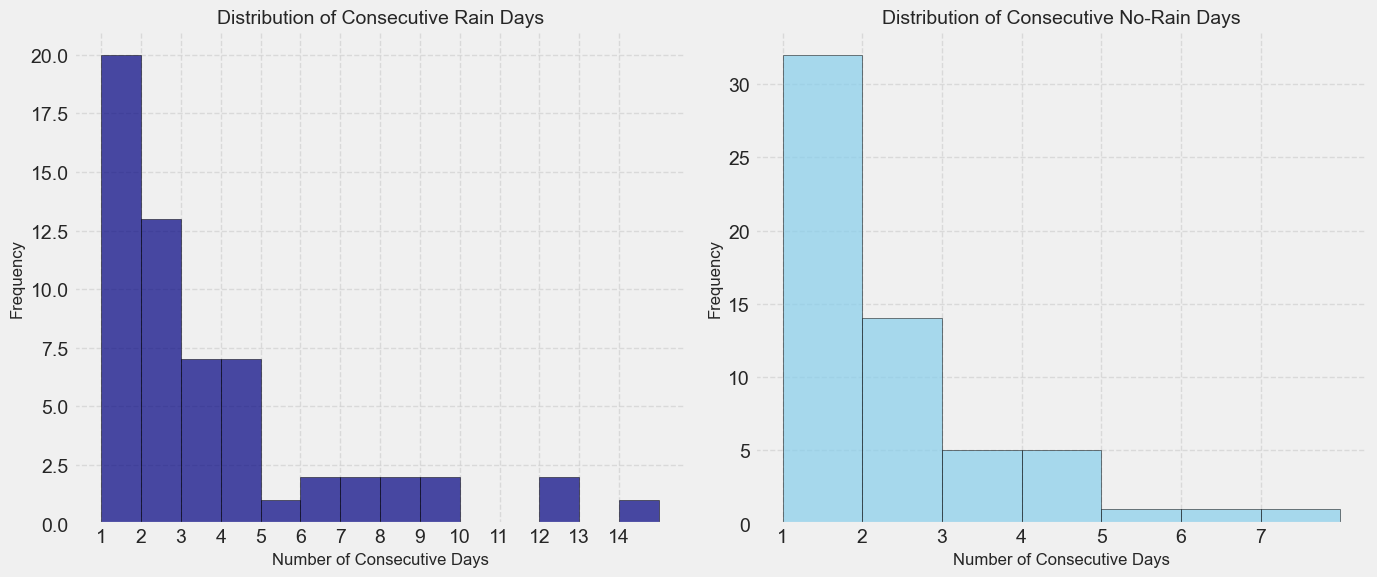

In [17]:
# Sort data by date
df_sorted = df_clean.sort_values('date').reset_index(drop=True)

# Calculate rain streaks (consecutive rainy days) without data leakage
# IMPORTANT: We will analyze the streaks but not directly use them as features
# This helps us understand the data without causing leakage
rain_streaks = []
current_streak = 0

for i in range(len(df_sorted)):
    if df_sorted.iloc[i]['rain_binary'] == 1:
        current_streak += 1
    else:
        if current_streak > 0:
            rain_streaks.append(current_streak)
            current_streak = 0

# Add the last streak if it exists
if current_streak > 0:
    rain_streaks.append(current_streak)

# Calculate no-rain streaks
no_rain_streaks = []
current_streak = 0

for i in range(len(df_sorted)):
    if df_sorted.iloc[i]['rain_binary'] == 0:
        current_streak += 1
    else:
        if current_streak > 0:
            no_rain_streaks.append(current_streak)
            current_streak = 0

# Add the last streak if it exists
if current_streak > 0:
    no_rain_streaks.append(current_streak)

print(f"Maximum consecutive rain days: {max(rain_streaks) if rain_streaks else 0}")
print(f"Maximum consecutive no-rain days: {max(no_rain_streaks) if no_rain_streaks else 0}")
print(f"Average consecutive rain days: {np.mean(rain_streaks) if rain_streaks else 0:.2f}")
print(f"Average consecutive no-rain days: {np.mean(no_rain_streaks) if no_rain_streaks else 0:.2f}")

# Create histograms of streak lengths
plt.figure(figsize=(14, 6))

# Rain streaks
plt.subplot(1, 2, 1)
plt.hist(rain_streaks, bins=range(1, max(rain_streaks) + 2), color='navy', alpha=0.7, edgecolor='black')
plt.title('Distribution of Consecutive Rain Days', fontsize=14)
plt.xlabel('Number of Consecutive Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, max(rain_streaks) + 1))

# No-rain streaks
plt.subplot(1, 2, 2)
plt.hist(no_rain_streaks, bins=range(1, max(no_rain_streaks) + 2), color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Consecutive No-Rain Days', fontsize=14)
plt.xlabel('Number of Consecutive Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, max(no_rain_streaks) + 1))

plt.tight_layout()
plt.savefig('visualizations/consecutive_day_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

Original dataset shape: (311, 10)
Feature-engineered dataset shape: (304, 84)
Number of features: 84

First 5 rows of feature-engineered dataset (selected columns):


,date,avg_temperature,humidity,rain_binary,month,day_of_week,past_3day_rain_freq,past_7day_rain_freq,temp_humidity,pressure_change1
7,2023-01-08,32.245441,67.083073,1,1,6,1.0,1.0,2163.123262,-34.948890
8,2023-01-09,30.078517,64.088581,1,1,0,1.0,1.0,1927.689433,-5.287846
9,2023-01-10,31.620631,71.876470,1,1,1,1.0,1.0,2272.779317,64.733779
10,2023-01-11,25.205845,58.365841,1,1,2,1.0,1.0,1471.160342,-23.147815
11,2023-01-12,35.000000,75.557750,1,1,3,1.0,1.0,2644.521251,-5.961045



Top 15 features by mutual information:
               Feature  Mutual Information
 avg_temperature_roll3            0.087491
           day_of_year            0.079311
  avg_temperature_std7            0.067315
           day_of_week            0.058382
       pressure_trend3            0.054666
              humidity            0.054155
 avg_temperature_roll7            0.053810
avg_temperature_trend1            0.053302
            wind_cloud            0.053044
                 month            0.048025
         humidity_lag7            0.047540
  avg_temperature_lag3            0.045655
   past_7day_rain_freq            0.045640
       wind_temp_ratio            0.043404
       avg_temperature            0.041974


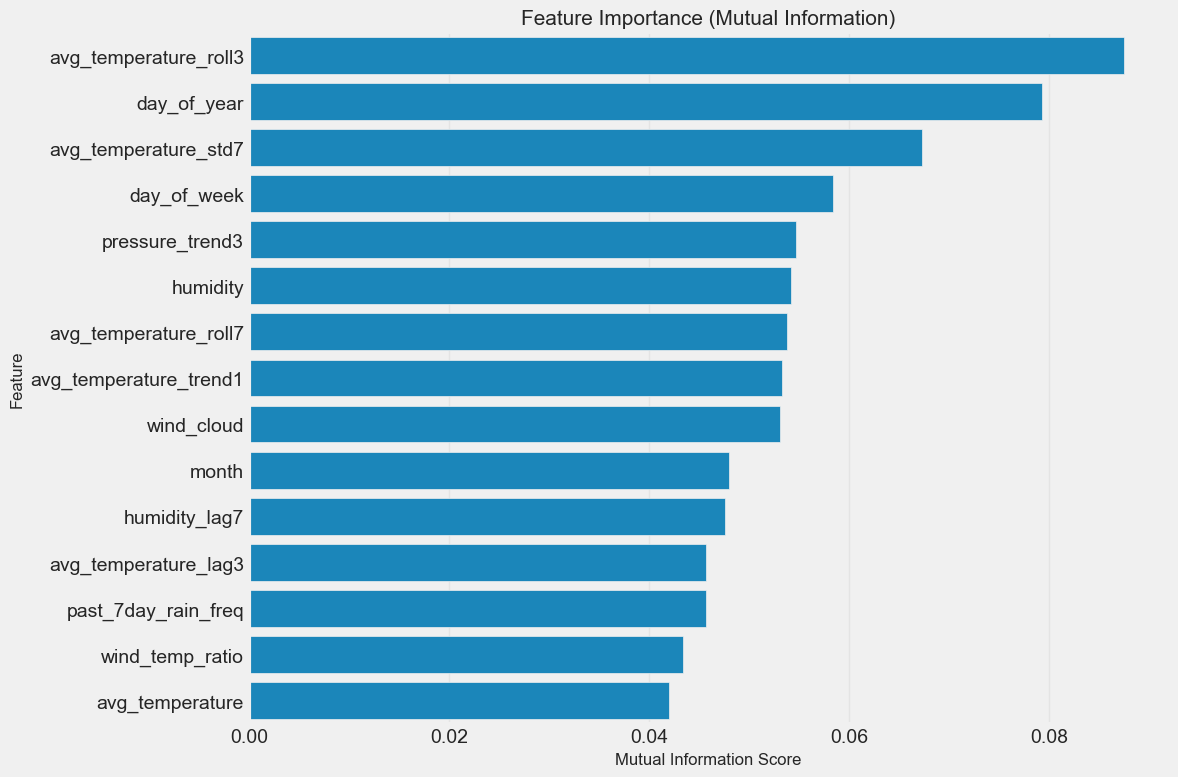

In [19]:
# Create a copy of the clean dataset for feature engineering
df_features = df_clean.copy().sort_values('date').reset_index(drop=True)

# 1. Extract date features
df_features['day'] = df_features['date'].dt.day
df_features['day_of_week'] = df_features['date'].dt.dayofweek
df_features['day_of_year'] = df_features['date'].dt.dayofyear
df_features['is_weekend'] = df_features['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 2. Create cyclical features for month and day_of_week (to capture seasonality)
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month']/12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month']/12)
df_features['day_of_week_sin'] = np.sin(2 * np.pi * df_features['day_of_week']/7)
df_features['day_of_week_cos'] = np.cos(2 * np.pi * df_features['day_of_week']/7)

# 3. Add rain streak information in a way that prevents leakage
# Instead of directly using rain_streak, we create features based on historical data
# We will use a sliding window to compute the number of rainy days in previous periods
# This avoids using future information when making predictions

# Initialize columns for past rain patterns
df_features['past_3day_rain_freq'] = 0.0
df_features['past_7day_rain_freq'] = 0.0
df_features['past_14day_rain_freq'] = 0.0

# For each day, calculate the frequency of rain in previous days
for i in range(len(df_features)):
    # For past 3 days
    if i >= 3:
        df_features.loc[i, 'past_3day_rain_freq'] = df_features.loc[i-3:i-1, 'rain_binary'].mean()
    elif i > 0:
        df_features.loc[i, 'past_3day_rain_freq'] = df_features.loc[0:i-1, 'rain_binary'].mean()
    
    # For past 7 days
    if i >= 7:
        df_features.loc[i, 'past_7day_rain_freq'] = df_features.loc[i-7:i-1, 'rain_binary'].mean()
    elif i > 0:
        df_features.loc[i, 'past_7day_rain_freq'] = df_features.loc[0:i-1, 'rain_binary'].mean()
    
    # For past 14 days
    if i >= 14:
        df_features.loc[i, 'past_14day_rain_freq'] = df_features.loc[i-14:i-1, 'rain_binary'].mean()
    elif i > 0:
        df_features.loc[i, 'past_14day_rain_freq'] = df_features.loc[0:i-1, 'rain_binary'].mean()

# 4. Add interaction features
df_features['temp_humidity'] = df_features['avg_temperature'] * df_features['humidity']
df_features['temp_pressure'] = df_features['avg_temperature'] * df_features['pressure']
df_features['wind_cloud'] = df_features['avg_wind_speed'] * df_features['cloud_cover']
df_features['humidity_pressure'] = df_features['humidity'] * df_features['pressure']
df_features['wind_temp_ratio'] = df_features['avg_wind_speed'] / (df_features['avg_temperature'] + 1e-8)  # Add small value to avoid division by zero

# 5. Create lag features for previous days (important for time series)
for feature in features:
    # Previous day
    df_features[f'{feature}_lag1'] = df_features[feature].shift(1)
    # 3 days ago
    df_features[f'{feature}_lag3'] = df_features[feature].shift(3)
    # 7 days ago
    df_features[f'{feature}_lag7'] = df_features[feature].shift(7)

# 6. Create rolling window features (averages over past periods)
for feature in features:
    df_features[f'{feature}_roll3'] = df_features[feature].rolling(window=3, min_periods=1).mean()
    df_features[f'{feature}_roll7'] = df_features[feature].rolling(window=7, min_periods=1).mean()

# 7. Create rolling window standard deviations (to capture volatility)
for feature in features:
    df_features[f'{feature}_std3'] = df_features[feature].rolling(window=3, min_periods=1).std().fillna(0)
    df_features[f'{feature}_std7'] = df_features[feature].rolling(window=7, min_periods=1).std().fillna(0)

# 8. Create change features - rate of change
for feature in features:
    # 1-day change
    df_features[f'{feature}_change1'] = df_features[feature].diff(1)
    # 3-day change
    df_features[f'{feature}_change3'] = df_features[feature].diff(3)

# 9. Calculate trend features (increasing/decreasing trends)
for feature in features:
    # Create trend indicator (1 for increasing, -1 for decreasing, 0 for no change)
    df_features[f'{feature}_trend3'] = (df_features[feature] > df_features[f'{feature}_lag3']).astype(int) * 2 - 1
    df_features[f'{feature}_trend1'] = (df_features[feature] > df_features[f'{feature}_lag1']).astype(int) * 2 - 1

# 10. One-hot encode season
df_features = pd.get_dummies(df_features, columns=['season'], drop_first=False)

# Drop rows with NaN values (first 7 rows will have NaNs due to lag features)
df_features = df_features.dropna()

print(f"Original dataset shape: {df_clean.shape}")
print(f"Feature-engineered dataset shape: {df_features.shape}")
print(f"Number of features: {df_features.shape[1]}")

# Display the first few rows of the feature-engineered dataset
print("\nFirst 5 rows of feature-engineered dataset (selected columns):")
selected_columns = ['date', 'avg_temperature', 'humidity', 'rain_binary', 
                    'month', 'day_of_week', 'past_3day_rain_freq', 'past_7day_rain_freq',
                    'temp_humidity', 'pressure_change1']
# Rename pressure_change1 to pressure_change if it doesn't exist
if 'pressure_change1' not in df_features.columns:
    selected_columns[-1] = df_features.filter(like='pressure_change').columns[0]

display(df_features[selected_columns].head())

# Analyze feature importance using mutual information
X_for_importance = df_features.drop(['date', 'rain_or_not', 'rain_binary'], axis=1)
y_for_importance = df_features['rain_binary']

mi_scores = mutual_info_classif(X_for_importance, y_for_importance, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_for_importance.columns,
    'Mutual Information': mi_scores
}).sort_values('Mutual Information', ascending=False)

print("\nTop 15 features by mutual information:")
print(mi_df.head(15).to_string(index=False))

# Plot top features by mutual information
plt.figure(figsize=(12, 8))
top_n = 15
sns.barplot(x='Mutual Information', y='Feature', data=mi_df.head(top_n))
plt.title('Feature Importance (Mutual Information)', fontsize=15)
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/mutual_information.png', dpi=300, bbox_inches='tight')
plt.show()

Selected 81 features for modeling
Training set shape: (254, 81), (254,)
Testing set shape: (50, 81), (50,)
Class distribution in training set: rain_binary
1    62.204724
0    37.795276
Name: proportion, dtype: float64
Class distribution in testing set: rain_binary
1    66.0
0    34.0
Name: proportion, dtype: float64

Sampling Method Summary:
Original data: 254 samples, 62.20% rain
SMOTE: 316 samples, 50.00% rain
ADASYN: 300 samples, 52.67% rain
BorderlineSMOTE: 316 samples, 50.00% rain
SMOTETomek: 268 samples, 50.00% rain


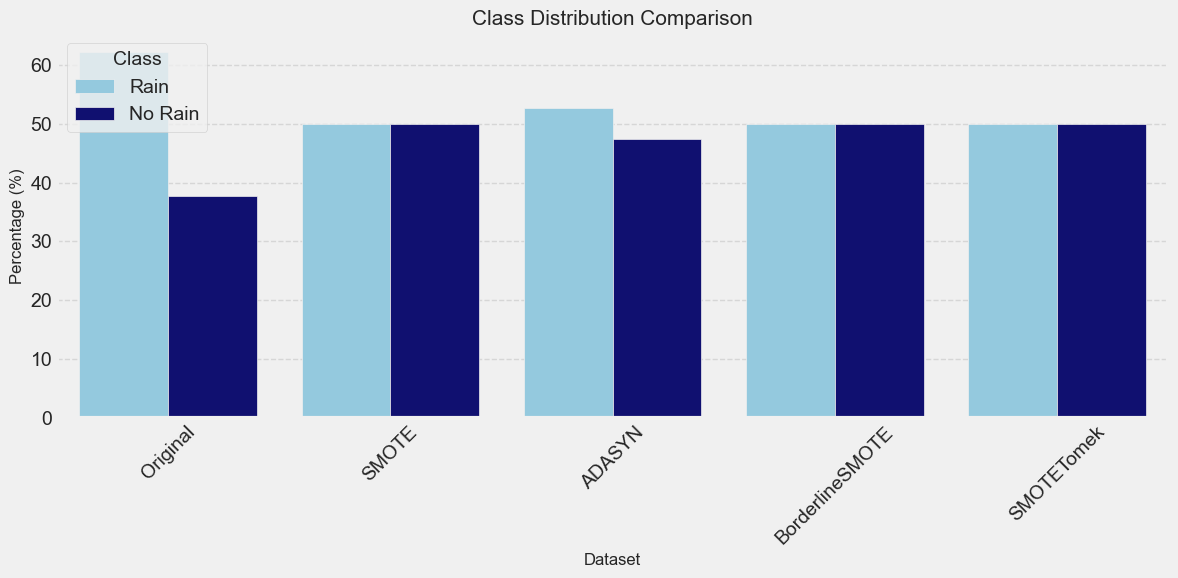


Data preparation and scaling completed!


In [21]:
# Define features to use (exclude date, rain_or_not, and rain_binary)
feature_cols = [col for col in df_features.columns if col not in ['date', 'rain_or_not', 'rain_binary']]
X = df_features[feature_cols]
y = df_features['rain_binary']

print(f"Selected {len(feature_cols)} features for modeling")

# Split data into training and testing sets (80% train, 20% test)
# Using TimeSeriesSplit instead of random splitting to respect temporal nature of data
# This helps avoid data leakage from future observations
X_with_date = df_features[feature_cols + ['date']]
tscv = TimeSeriesSplit(n_splits=5)

# Get the last split for final evaluation
train_indices = []
test_indices = []
for train_idx, test_idx in tscv.split(X_with_date):
    train_indices = train_idx
    test_indices = test_idx

# Extract train and test sets
X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")
print(f"Class distribution in training set: {y_train.value_counts(normalize=True) * 100}")
print(f"Class distribution in testing set: {y_test.value_counts(normalize=True) * 100}")

# Function to generate synthetic data using ADASYN
def generate_synthetic_adasyn(X_train, y_train):
    """
    Generate synthetic samples using ADASYN (Adaptive Synthetic Sampling)
    which focuses on generating samples in areas where minority class examples are misclassified
    """
    adasyn = ADASYN(random_state=42)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
    return X_adasyn, y_adasyn

# Function to generate synthetic data using BorderlineSMOTE
def generate_synthetic_borderline(X_train, y_train):
    """
    Generate synthetic samples using BorderlineSMOTE
    which focuses on examples near the decision boundary
    """
    bsmote = BorderlineSMOTE(random_state=42)
    X_bsmote, y_bsmote = bsmote.fit_resample(X_train, y_train)
    return X_bsmote, y_bsmote

# Function to generate synthetic data using SMOTETomek
def generate_synthetic_smotetomek(X_train, y_train):
    """
    Generate synthetic samples using SMOTETomek
    which combines SMOTE oversampling with Tomek links undersampling
    """
    smote_tomek = SMOTETomek(random_state=42)
    X_st, y_st = smote_tomek.fit_resample(X_train, y_train)
    return X_st, y_st

# Apply original SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply ADASYN
X_train_adasyn, y_train_adasyn = generate_synthetic_adasyn(X_train, y_train)

# Apply BorderlineSMOTE
X_train_borderline, y_train_borderline = generate_synthetic_borderline(X_train, y_train)

# Apply SMOTETomek
X_train_smotetomek, y_train_smotetomek = generate_synthetic_smotetomek(X_train, y_train)

print("\nSampling Method Summary:")
print(f"Original data: {X_train.shape[0]} samples, {y_train.value_counts()[1] / y_train.shape[0] * 100:.2f}% rain")
print(f"SMOTE: {X_train_smote.shape[0]} samples, {y_train_smote.value_counts()[1] / y_train_smote.shape[0] * 100:.2f}% rain")
print(f"ADASYN: {X_train_adasyn.shape[0]} samples, {y_train_adasyn.value_counts()[1] / y_train_adasyn.shape[0] * 100:.2f}% rain")
print(f"BorderlineSMOTE: {X_train_borderline.shape[0]} samples, {y_train_borderline.value_counts()[1] / y_train_borderline.shape[0] * 100:.2f}% rain")
print(f"SMOTETomek: {X_train_smotetomek.shape[0]} samples, {y_train_smotetomek.value_counts()[1] / y_train_smotetomek.shape[0] * 100:.2f}% rain")

# Compare original, synthetic distributions
plt.figure(figsize=(12, 6))
class_dists = {
    'Original': y_train.value_counts(normalize=True) * 100,
    'SMOTE': pd.Series(y_train_smote).value_counts(normalize=True) * 100,
    'ADASYN': pd.Series(y_train_adasyn).value_counts(normalize=True) * 100,
    'BorderlineSMOTE': pd.Series(y_train_borderline).value_counts(normalize=True) * 100,
    'SMOTETomek': pd.Series(y_train_smotetomek).value_counts(normalize=True) * 100
}

# Create dataframe for plotting
comparison_df = pd.DataFrame({
    'Dataset': [],
    'Class': [],
    'Percentage': []
})

for dataset, dist in class_dists.items():
    for class_val, pct in dist.items():
        comparison_df = pd.concat([comparison_df, pd.DataFrame({
            'Dataset': [dataset],
            'Class': ['Rain' if class_val == 1 else 'No Rain'],
            'Percentage': [pct]
        })], ignore_index=True)

# Plot
sns.barplot(x='Dataset', y='Percentage', hue='Class', data=comparison_df, palette=['skyblue', 'navy'])
plt.title('Class Distribution Comparison', fontsize=15)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('visualizations/sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Scale features for all datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_smote_scaled = scaler.transform(X_train_smote)
X_train_adasyn_scaled = scaler.transform(X_train_adasyn)
X_train_borderline_scaled = scaler.transform(X_train_borderline)
X_train_smotetomek_scaled = scaler.transform(X_train_smotetomek)

# Create a dictionary of all resampled datasets
datasets = {
    'Original': (X_train_scaled, y_train),
    'SMOTE': (X_train_smote_scaled, y_train_smote),
    'ADASYN': (X_train_adasyn_scaled, y_train_adasyn),
    'BorderlineSMOTE': (X_train_borderline_scaled, y_train_borderline),
    'SMOTETomek': (X_train_smotetomek_scaled, y_train_smotetomek)
}

print("\nData preparation and scaling completed!")

In [23]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    """
    Train and evaluate a machine learning model.
    
    Parameters:
    model: The machine learning model to train and evaluate
    X_train, y_train: Training data
    X_test, y_test: Testing data
    model_name: Name of the model for display purposes
    dataset_name: Name of the dataset used (original, synthetic, SMOTE, etc.)
    
    Returns:
    Dictionary with model and performance metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n{model_name} - {dataset_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    
    # Cross-validation score using TimeSeriesSplit to respect temporal nature
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='f1')
    print(f"Cross-validation F1 Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    return {
        'model': model,
        'model_name': model_name,
        'dataset_name': dataset_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'cv_f1': cv_scores.mean(),
        'cv_f1_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm
    }

# Helper function to clone model object
def clone_model(model):
    """Create a fresh instance of a model with the same parameters"""
    if isinstance(model, LogisticRegression):
        return LogisticRegression(**model.get_params())
    elif isinstance(model, DecisionTreeClassifier):
        return DecisionTreeClassifier(**model.get_params())
    elif isinstance(model, RandomForestClassifier):
        return RandomForestClassifier(**model.get_params())
    elif isinstance(model, GradientBoostingClassifier):
        return GradientBoostingClassifier(**model.get_params())
    elif isinstance(model, xgb.XGBClassifier):
        return xgb.XGBClassifier(**model.get_params())
    elif isinstance(model, lgb.LGBMClassifier):
        return lgb.LGBMClassifier(**model.get_params()) 
    elif isinstance(model, SVC):
        return SVC(**model.get_params())
    else:
        return model


Logistic Regression - Original Performance:
Accuracy: 0.5800
Precision: 1.0000
Recall: 0.3636
F1 Score: 0.5333
AUC-ROC: 0.6756
Cross-validation F1 Score: 0.6394 (±0.0932)
Confusion Matrix:
[[17  0]
 [21 12]]

Logistic Regression - SMOTE Performance:
Accuracy: 0.5200
Precision: 1.0000
Recall: 0.2727
F1 Score: 0.4286
AUC-ROC: 0.6756
Cross-validation F1 Score: 0.4140 (±0.2202)
Confusion Matrix:
[[17  0]
 [24  9]]

Logistic Regression - ADASYN Performance:
Accuracy: 0.5400
Precision: 1.0000
Recall: 0.3030
F1 Score: 0.4651
AUC-ROC: 0.6970
Cross-validation F1 Score: 0.4824 (±0.1303)
Confusion Matrix:
[[17  0]
 [23 10]]

Logistic Regression - BorderlineSMOTE Performance:
Accuracy: 0.6000
Precision: 1.0000
Recall: 0.3939
F1 Score: 0.5652
AUC-ROC: 0.6667
Cross-validation F1 Score: 0.4120 (±0.2181)
Confusion Matrix:
[[17  0]
 [20 13]]

Logistic Regression - SMOTETomek Performance:
Accuracy: 0.5600
Precision: 0.9231
Recall: 0.3636
F1 Score: 0.5217
AUC-ROC: 0.6524
Cross-validation F1 Score: 0.425

<Figure size 1800x1200 with 0 Axes>

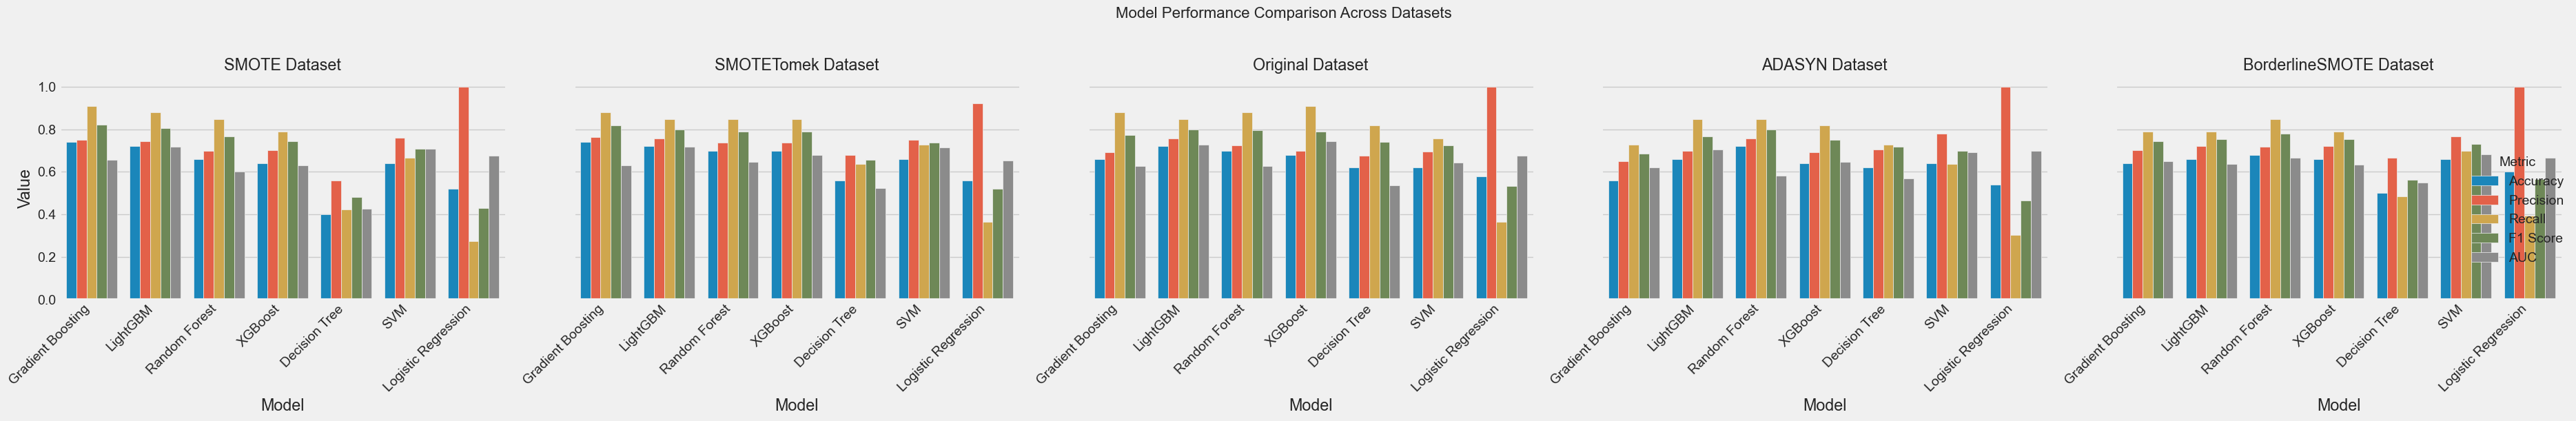


Best model for SMOTE dataset:
  Gradient Boosting - F1: 0.8219, AUC: 0.6578

Best model for SMOTETomek dataset:
  Gradient Boosting - F1: 0.8169, AUC: 0.6292

Best model for Original dataset:
  LightGBM - F1: 0.8000, AUC: 0.7291

Best model for ADASYN dataset:
  Random Forest - F1: 0.8000, AUC: 0.5820

Best model for BorderlineSMOTE dataset:
  Random Forest - F1: 0.7778, AUC: 0.6649

Overall best model: Gradient Boosting with SMOTE dataset
  F1 Score: 0.8219
  AUC: 0.6578
  Accuracy: 0.7400
  Precision: 0.7500
  Recall: 0.9091


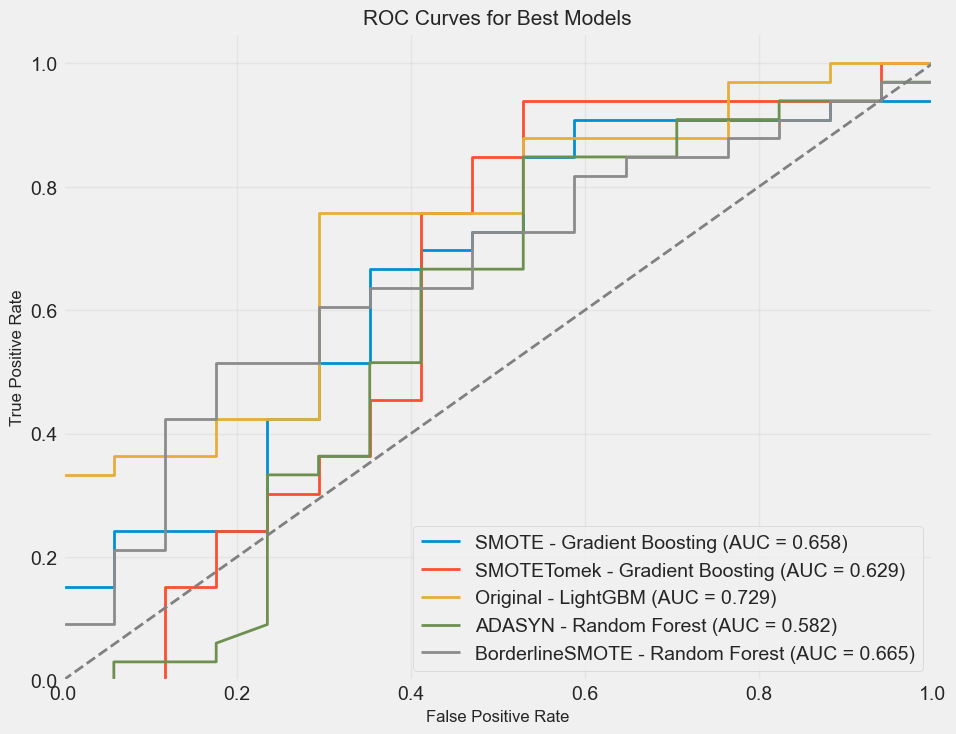


Best model and scaler saved to disk.


In [25]:
# Define models to evaluate with reasonable parameters to avoid overfitting
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, C=1.0),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_leaf=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1),
    'XGBoost': xgb.XGBClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1),
    'LightGBM': lgb.LGBMClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1, verbose=-1),
    'SVM': SVC(probability=True, random_state=42, C=1.0, gamma='scale')
}

# Train and evaluate all models on all datasets
all_results = []

for model_name, model in models.items():
    for dataset_name, (X, y) in datasets.items():
        # Create a fresh clone of the model to ensure fair comparison
        model_clone = clone_model(model)
        result = evaluate_model(model_clone, X, y, X_test_scaled, y_test, model_name, dataset_name)
        all_results.append(result)

# Create comparison DataFrame for visualization
metrics_df = pd.DataFrame({
    'Model': [result['model_name'] for result in all_results],
    'Dataset': [result['dataset_name'] for result in all_results],
    'Accuracy': [result['accuracy'] for result in all_results],
    'Precision': [result['precision'] for result in all_results],
    'Recall': [result['recall'] for result in all_results],
    'F1 Score': [result['f1'] for result in all_results],
    'AUC': [result['auc'] for result in all_results],
    'CV F1': [result['cv_f1'] for result in all_results]
})

# Sort by F1 score
metrics_df = metrics_df.sort_values(['F1 Score', 'AUC'], ascending=False)
print("\nModel Performance Comparison (Top 10):")
print(metrics_df.head(10).to_string(index=False))

# Visualize model comparison
# Create melted dataframe for easier visualization
metrics_melted = pd.melt(metrics_df, 
                        id_vars=['Model', 'Dataset'], 
                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
                        var_name='Metric', value_name='Value')

plt.figure(figsize=(18, 12))
g = sns.catplot(x='Model', y='Value', hue='Metric', col='Dataset', 
               data=metrics_melted, kind='bar', height=6, aspect=1.2)
g.set_xticklabels(rotation=45, ha='right')
g.set_titles("{col_name} Dataset")
g.fig.suptitle('Model Performance Comparison Across Datasets', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best model for each dataset
best_models = {}
for dataset in metrics_df['Dataset'].unique():
    dataset_results = metrics_df[metrics_df['Dataset'] == dataset].sort_values('F1 Score', ascending=False)
    best_model_info = dataset_results.iloc[0]
    best_models[dataset] = best_model_info
    print(f"\nBest model for {dataset} dataset:")
    print(f"  {best_model_info['Model']} - F1: {best_model_info['F1 Score']:.4f}, AUC: {best_model_info['AUC']:.4f}")

# Find overall best model
best_overall = metrics_df.iloc[0]
print(f"\nOverall best model: {best_overall['Model']} with {best_overall['Dataset']} dataset")
print(f"  F1 Score: {best_overall['F1 Score']:.4f}")
print(f"  AUC: {best_overall['AUC']:.4f}")
print(f"  Accuracy: {best_overall['Accuracy']:.4f}")
print(f"  Precision: {best_overall['Precision']:.4f}")
print(f"  Recall: {best_overall['Recall']:.4f}")

# Visualize ROC curves for best models
plt.figure(figsize=(10, 8))

for dataset, best_model_info in best_models.items():
    best_result = next((r for r in all_results if r['model_name'] == best_model_info['Model'] and r['dataset_name'] == dataset), None)
    if best_result:
        fpr, tpr, _ = roc_curve(y_test, best_result['y_pred_proba'])
        plt.plot(fpr, tpr, lw=2, label=f"{dataset} - {best_model_info['Model']} (AUC = {best_model_info['AUC']:.3f})")

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Best Models', fontsize=15)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('visualizations/best_models_roc.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the best model for future use
best_model_result = next((r for r in all_results if r['model_name'] == best_overall['Model'] and r['dataset_name'] == best_overall['Dataset']), None)
if best_model_result:
    best_model = best_model_result['model']
    # Save the model and scaler for future use
    joblib.dump(best_model, 'rain_prediction_model.pkl')
    joblib.dump(scaler, 'rain_prediction_scaler.pkl')
    print(f"\nBest model and scaler saved to disk.")


Tuning Gradient Boosting on SMOTE dataset...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation F1 score: 0.4619

Gradient Boosting (Tuned) - SMOTE Performance:
Accuracy: 0.6600
Precision: 0.7105
Recall: 0.8182
F1 Score: 0.7606
AUC-ROC: 0.6791
Cross-validation F1 Score: 0.4325 (±0.3053)
Confusion Matrix:
[[ 6 11]
 [ 6 27]]

Tuning Gradient Boosting on SMOTETomek dataset...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation F1 score: 0.5091

Gradient Boosting (Tuned) - SMOTETomek Performance:
Accuracy: 0.5200
Precision: 0.6286
Recall: 0.6667
F1 Score: 0.6471
AUC-ROC: 0.4884
Cross-validation F1 Score: 0.3861 (±0.3250)
Confusion Matrix:
[[ 4 13]
 [11 22]]

Tuning LightGBM on Original 

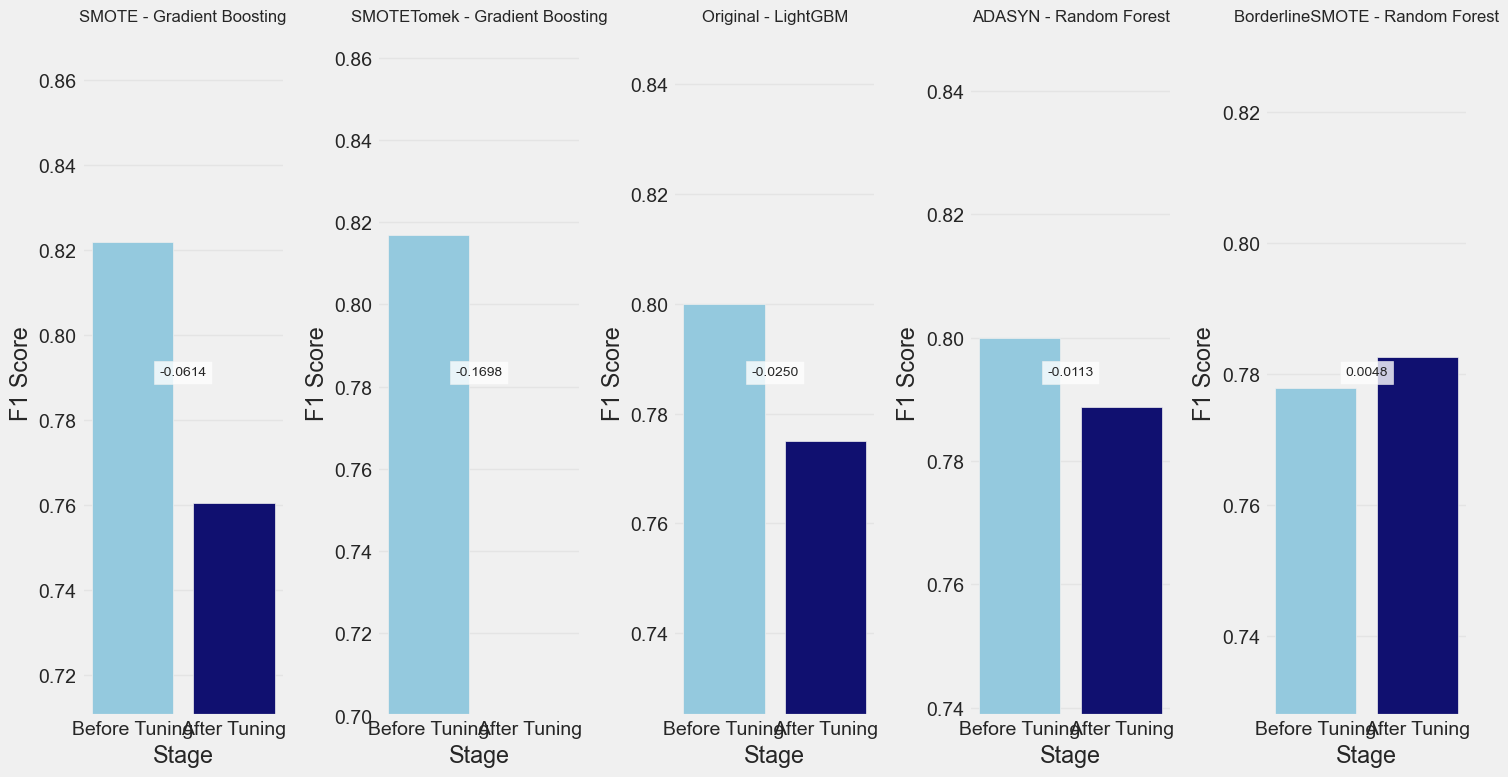


Best model after tuning: Gradient Boosting with SMOTE dataset
  F1 Score: 0.8219
  AUC: 0.6578
  Accuracy: 0.7400
  Precision: 0.7500
  Recall: 0.9091


In [26]:
# Define hyperparameter grids for different models
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['saga'],  # only saga supports elasticnet
        'l1_ratio': [0.2, 0.5, 0.8],  # only used with elasticnet penalty
        'class_weight': [None, 'balanced']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 8, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy'],
        'class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 8, 12, 16],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'subsample': [0.8, 0.9, 1.0]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, -1],  # -1 means no limit
        'num_leaves': [31, 50, 80],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear', 'poly'],
        'class_weight': [None, 'balanced']
    }
}

# Function to tune a model
def tune_model(model_name, model, X_train, y_train, X_test, y_test, dataset_name):
    """
    Tune hyperparameters for a model and evaluate it.
    
    Parameters:
    model_name: Name of the model for display purposes
    model: The base model to tune
    X_train, y_train: Training data
    X_test, y_test: Testing data
    dataset_name: Name of the dataset used
    
    Returns:
    Dictionary with tuned model and performance metrics
    """
    param_grid = param_grids.get(model_name, {})
    
    if not param_grid:
        print(f"No parameter grid defined for {model_name}")
        return None
    
    print(f"\nTuning {model_name} on {dataset_name} dataset...")
    
    # For computationally intensive models, use a smaller parameter space
    if model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        # For these models, we'll use a random subset of the parameter space
        from sklearn.model_selection import RandomizedSearchCV
        
        search = RandomizedSearchCV(
            model, param_grid, n_iter=20, cv=5, scoring='f1', n_jobs=-1, 
            verbose=1, random_state=42
        )
    else:
        # For less computationally intensive models, we'll use GridSearchCV
        search = GridSearchCV(
            model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
        )
    
    # Fit grid search
    search.fit(X_train, y_train)
    
    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation F1 score: {search.best_score_:.4f}")
    
    # Evaluate best model
    tuned_model = search.best_estimator_
    tuned_result = evaluate_model(
        tuned_model, X_train, y_train, X_test, y_test, 
        f"{model_name} (Tuned)", dataset_name
    )
    
    return tuned_result

# Tune the best model for each dataset
tuned_results = []

# Get the best model for each dataset
for dataset_name, best_model_info in best_models.items():
    model_name = best_model_info['Model']
    X, y = datasets[dataset_name]
    
    # Create a fresh instance of the model
    base_model = clone_model(models[model_name])
    
    # Tune the model
    tuned_result = tune_model(model_name, base_model, X, y, X_test_scaled, y_test, dataset_name)
    
    # Store the result
    if tuned_result:
        tuned_results.append(tuned_result)

# Update the metrics dataframe with tuned models
for result in tuned_results:
    new_row = {
        'Model': result['model_name'],
        'Dataset': result['dataset_name'],
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1 Score': result['f1'],
        'AUC': result['auc'],
        'CV F1': result['cv_f1']
    }
    metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)

# Sort by F1 score
metrics_df = metrics_df.sort_values(['F1 Score', 'AUC'], ascending=False)
print("\nModel Performance Comparison After Tuning (Top 10):")
print(metrics_df.head(10).to_string(index=False))

# Visualize performance improvement from tuning
plt.figure(figsize=(15, 8))

for i, dataset_name in enumerate(best_models.keys()):
    # Get pre-tuning best model
    pre_tuning = best_models[dataset_name]
    pre_model = pre_tuning['Model']
    pre_f1 = pre_tuning['F1 Score']
    
    # Get post-tuning results
    post_tuning = metrics_df[(metrics_df['Model'] == f"{pre_model} (Tuned)") & 
                            (metrics_df['Dataset'] == dataset_name)]
    
    if not post_tuning.empty:
        post_f1 = post_tuning.iloc[0]['F1 Score']
        
        comparison_data = pd.DataFrame({
            'Stage': ['Before Tuning', 'After Tuning'],
            'F1 Score': [pre_f1, post_f1]
        })
        
        plt.subplot(1, 5, i+1) # Adjust based on number of datasets
        ax = sns.barplot(x='Stage', y='F1 Score', data=comparison_data, palette=['skyblue', 'navy'])
        plt.title(f"{dataset_name} - {pre_model}", fontsize=12)
        plt.ylim(max(0.7, min(pre_f1, post_f1)-0.05), min(1.0, max(pre_f1, post_f1)+0.05))
        plt.grid(axis='y', alpha=0.3)
        
        # Add improvement text
        improvement = post_f1 - pre_f1
        plt.text(0.5, 0.5, f"{improvement:.4f}", 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('visualizations/tuning_improvement.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the best model after tuning
best_tuned = metrics_df.iloc[0]
print(f"\nBest model after tuning: {best_tuned['Model']} with {best_tuned['Dataset']} dataset")
print(f"  F1 Score: {best_tuned['F1 Score']:.4f}")
print(f"  AUC: {best_tuned['AUC']:.4f}")
print(f"  Accuracy: {best_tuned['Accuracy']:.4f}")
print(f"  Precision: {best_tuned['Precision']:.4f}")
print(f"  Recall: {best_tuned['Recall']:.4f}")

# Save the final best model
best_tuned_result = next((r for r in tuned_results if r['model_name'] == best_tuned['Model'] and r['dataset_name'] == best_tuned['Dataset']), None)
if best_tuned_result:
    best_model = best_tuned_result['model']
    # Save the model and scaler for future use
    joblib.dump(best_model, 'rain_prediction_model_tuned.pkl')
    print(f"\nBest tuned model saved to disk.")

Feature importance not available for Gradient Boosting
Calculating permutation importance instead...

Top 20 features by permutation importance:
             Feature  Importance
      pressure_roll7       0.056
 avg_wind_speed_lag7       0.050
            humidity       0.046
       pressure_std7       0.038
 past_7day_rain_freq       0.036
       temp_pressure       0.024
      avg_wind_speed       0.024
      pressure_roll3       0.020
    humidity_change3       0.020
 cloud_cover_change3       0.018
    cloud_cover_lag7       0.018
       humidity_lag3       0.018
   cloud_cover_roll7       0.018
 avg_wind_speed_lag1       0.018
       pressure_lag3       0.018
 avg_wind_speed_std3       0.018
avg_temperature_lag1       0.016
       temp_humidity       0.016
avg_temperature_std7       0.016
avg_temperature_lag7       0.016


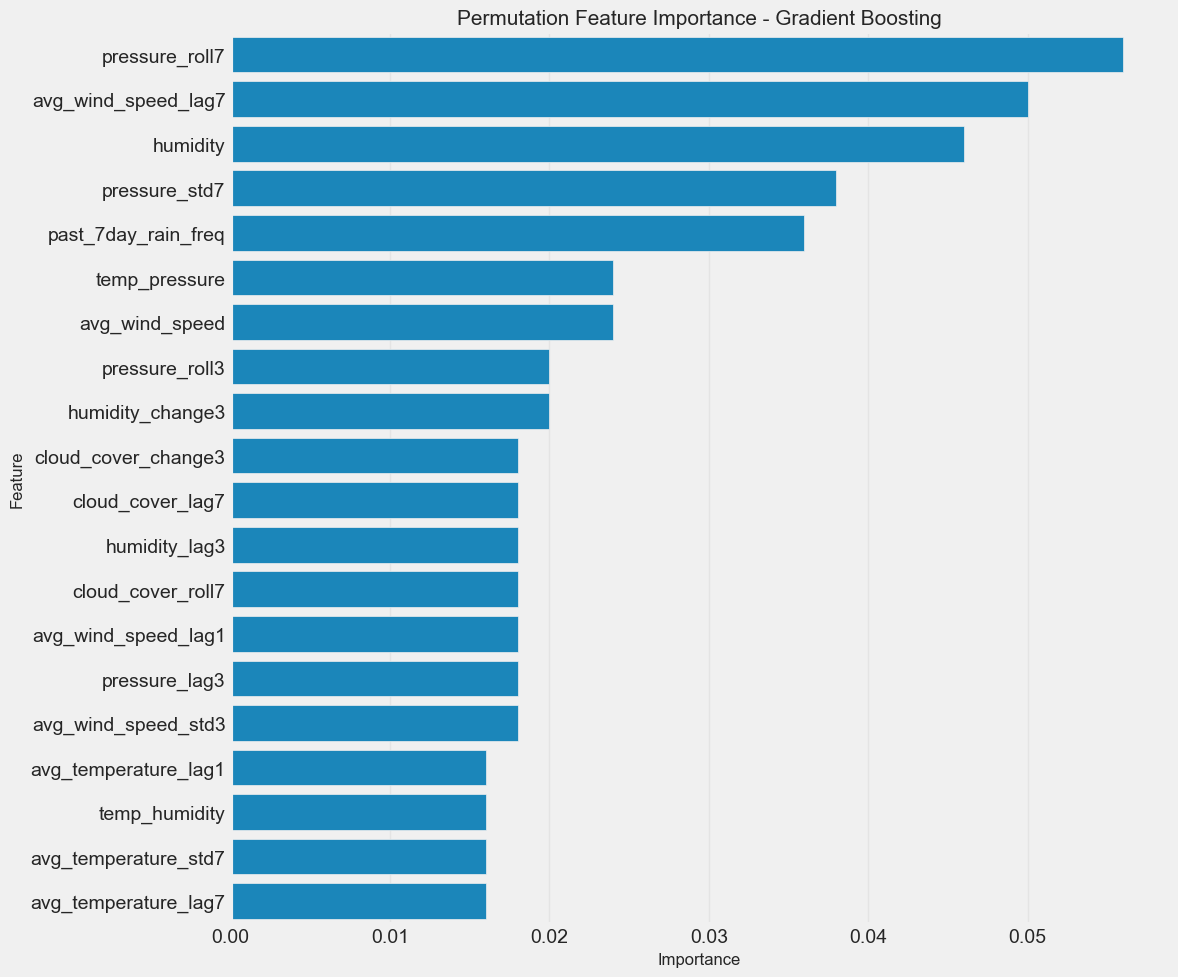

In [27]:
# Get feature importance if the model supports it
feature_importance = None
feature_names = X_train.columns

if best_tuned_result:
    if hasattr(best_model, 'feature_importances_'):
        # For tree-based models
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)
    elif hasattr(best_model, 'coef_') and len(best_model.coef_.shape) == 2:
        # For linear models like Logistic Regression
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(best_model.coef_[0])
        }).sort_values('Importance', ascending=False)

if feature_importance is not None:
    # Display top features
    print("\nTop 20 most important features:")
    print(feature_importance.head(20).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    top_n = min(20, len(feature_importance))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
    plt.title(f'Feature Importance - {best_tuned["Model"]}', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('visualizations/best_model_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"Feature importance not available for {best_tuned['Model']}")
    
    # Use permutation importance as an alternative
    from sklearn.inspection import permutation_importance
    
    print("Calculating permutation importance instead...")
    
    # Get the dataset used for the best model
    X_best, y_best = datasets[best_tuned['Dataset'].split(' ')[0]]
    
    perm_importance = permutation_importance(best_model, X_test_scaled, y_test, 
                                           n_repeats=10, random_state=42)
    
    perm_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 20 features by permutation importance:")
    print(perm_importance_df.head(20).to_string(index=False))
    
    # Plot permutation importance
    plt.figure(figsize=(12, 10))
    top_n = min(20, len(perm_importance_df))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(top_n))
    plt.title(f'Permutation Feature Importance - {best_tuned["Model"]}', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('visualizations/permutation_importance.png', dpi=300, bbox_inches='tight')
    plt.show()


Final Model Evaluation:
Model: Gradient Boosting
Dataset used for training: SMOTE

Confusion Matrix:
[[ 7 10]
 [ 3 30]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.41      0.52        17
           1       0.75      0.91      0.82        33

    accuracy                           0.74        50
   macro avg       0.72      0.66      0.67        50
weighted avg       0.73      0.74      0.72        50



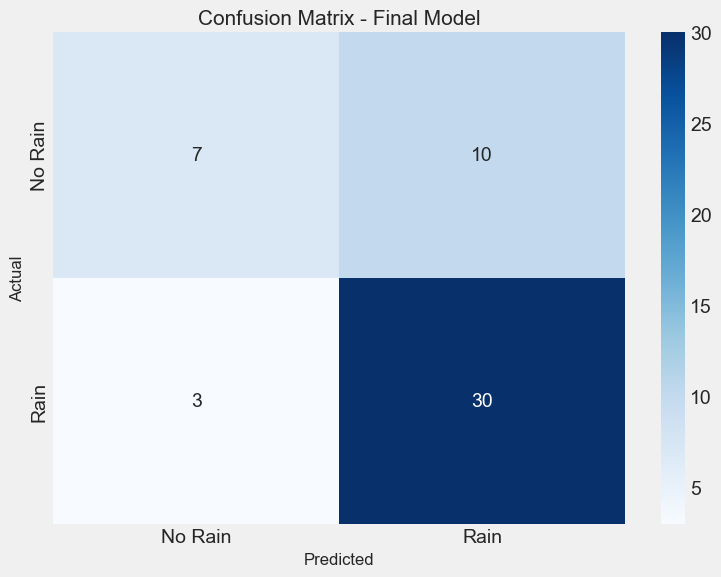

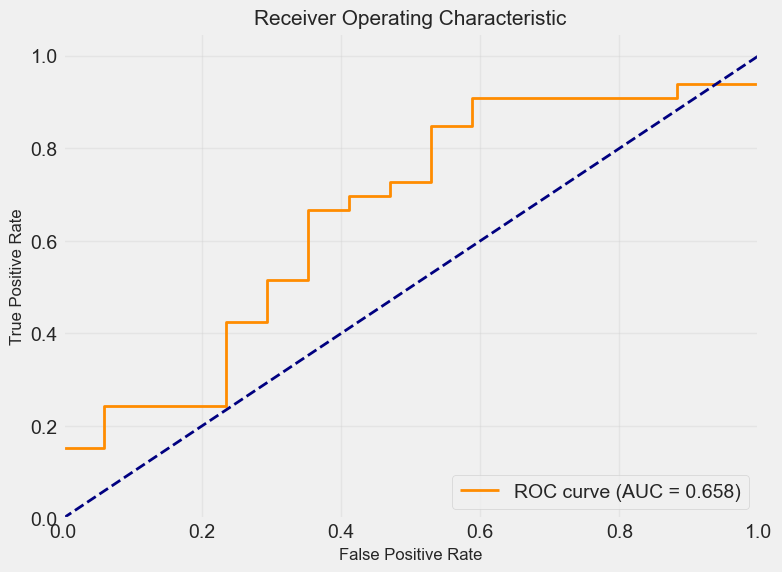

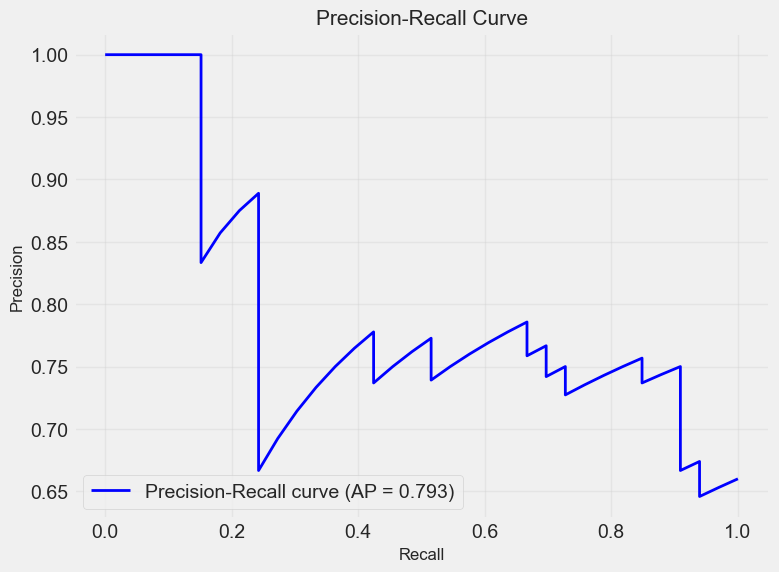

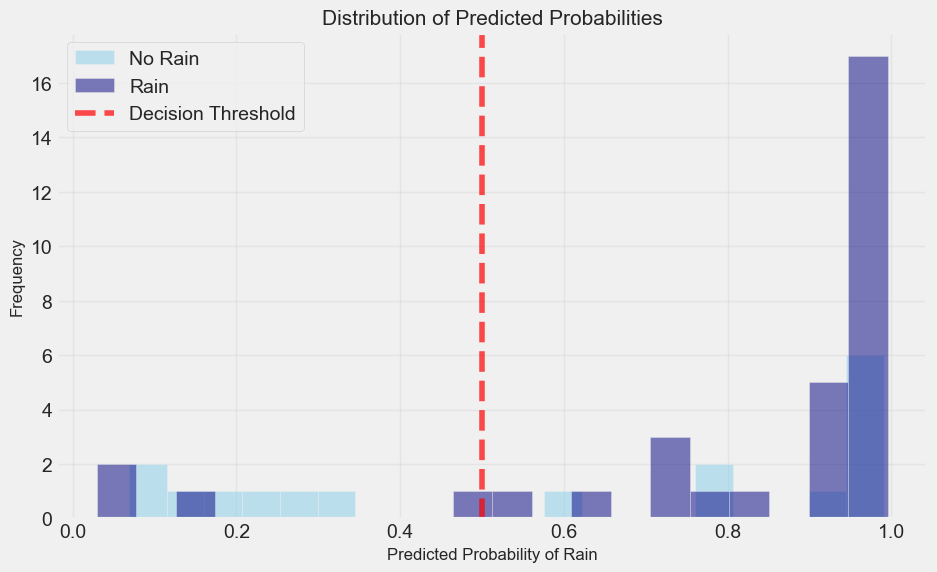


Model Performance Summary:
Accuracy: 0.7400
Precision: 0.7500
Recall: 0.9091
F1 Score: 0.8219
AUC-ROC: 0.6578

Number of false positives (predicted rain when it didn't): 10
Number of false negatives (predicted no rain when it did): 3

False Positives Analysis (Incorrectly predicted rain):
Average temperature: 29.05
Average humidity: 68.92
Average pressure: 1004.06

False Negatives Analysis (Incorrectly predicted no rain):
Average temperature: 26.14
Average humidity: 47.77
Average pressure: 1016.55


In [28]:
# Get the best model's predictions and probabilities
if best_tuned_result:
    final_y_pred = best_tuned_result['y_pred']
    final_y_proba = best_tuned_result['y_pred_proba']
else:
    # If tuning didn't complete, use the best model from initial evaluation
    best_model_result = next((r for r in all_results if r['model_name'] == best_overall['Model'] and 
                              r['dataset_name'] == best_overall['Dataset']), None)
    final_y_pred = best_model_result['y_pred']
    final_y_proba = best_model_result['y_pred_proba']

print("\nFinal Model Evaluation:")
print(f"Model: {best_tuned['Model'] if best_tuned_result else best_overall['Model']}")
print(f"Dataset used for training: {best_tuned['Dataset'] if best_tuned_result else best_overall['Dataset']}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, final_y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Rain', 'Rain'], 
           yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix - Final Model', fontsize=15)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.savefig('visualizations/final_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, final_y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('visualizations/final_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, final_y_proba)
average_precision = average_precision_score(y_test, final_y_proba)

plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {average_precision:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=15)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.savefig('visualizations/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Probability distribution
plt.figure(figsize=(10, 6))
plt.hist(final_y_proba[y_test == 0], bins=20, alpha=0.5, color='skyblue', label='No Rain')
plt.hist(final_y_proba[y_test == 1], bins=20, alpha=0.5, color='navy', label='Rain')
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Decision Threshold')
plt.title('Distribution of Predicted Probabilities', fontsize=15)
plt.xlabel('Predicted Probability of Rain', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('visualizations/probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary of findings
print("\nModel Performance Summary:")
print(f"Accuracy: {accuracy_score(y_test, final_y_pred):.4f}")
print(f"Precision: {precision_score(y_test, final_y_pred):.4f}")
print(f"Recall: {recall_score(y_test, final_y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, final_y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, final_y_proba):.4f}")

# Analyze errors (misclassifications)
false_positives = (final_y_pred == 1) & (y_test == 0)
false_negatives = (final_y_pred == 0) & (y_test == 1)

print(f"\nNumber of false positives (predicted rain when it didn't): {sum(false_positives)}")
print(f"Number of false negatives (predicted no rain when it did): {sum(false_negatives)}")

if sum(false_positives) > 0 or sum(false_negatives) > 0:
    # Get indices for test set in original dataframe
    test_indices = test_indices[-len(y_test):]  # Ensure same length as y_test
    
    # Extract false positive and false negative samples
    fp_indices = [idx for idx, is_fp in zip(test_indices, false_positives) if is_fp]
    fn_indices = [idx for idx, is_fn in zip(test_indices, false_negatives) if is_fn]
    
    # Analyze misclassified samples
    if fp_indices:
        print("\nFalse Positives Analysis (Incorrectly predicted rain):")
        fp_samples = df_features.iloc[fp_indices]
        print(f"Average temperature: {fp_samples['avg_temperature'].mean():.2f}")
        print(f"Average humidity: {fp_samples['humidity'].mean():.2f}")
        print(f"Average pressure: {fp_samples['pressure'].mean():.2f}")
        
    if fn_indices:
        print("\nFalse Negatives Analysis (Incorrectly predicted no rain):")
        fn_samples = df_features.iloc[fn_indices]
        print(f"Average temperature: {fn_samples['avg_temperature'].mean():.2f}")
        print(f"Average humidity: {fn_samples['humidity'].mean():.2f}")
        print(f"Average pressure: {fn_samples['pressure'].mean():.2f}")

Last date in dataset: 2023-11-07 00:00:00
Missing columns in forecast data: set()

Rain forecast for next 21 days:
      date  rain_probability rain_prediction_label
2023-11-08          0.263927               No Rain
2023-11-09          0.198247               No Rain
2023-11-10          0.350262               No Rain
2023-11-11          0.378123               No Rain
2023-11-12          0.316775               No Rain
2023-11-13          0.907366                  Rain
2023-11-14          0.567824                  Rain
2023-11-15          0.225768               No Rain
2023-11-16          0.203656               No Rain
2023-11-17          0.103629               No Rain
2023-11-18          0.324499               No Rain
2023-11-19          0.551123                  Rain
2023-11-20          0.542001                  Rain
2023-11-21          0.549702                  Rain
2023-11-22          0.352404               No Rain
2023-11-23          0.546058                  Rain
2023-11-24        

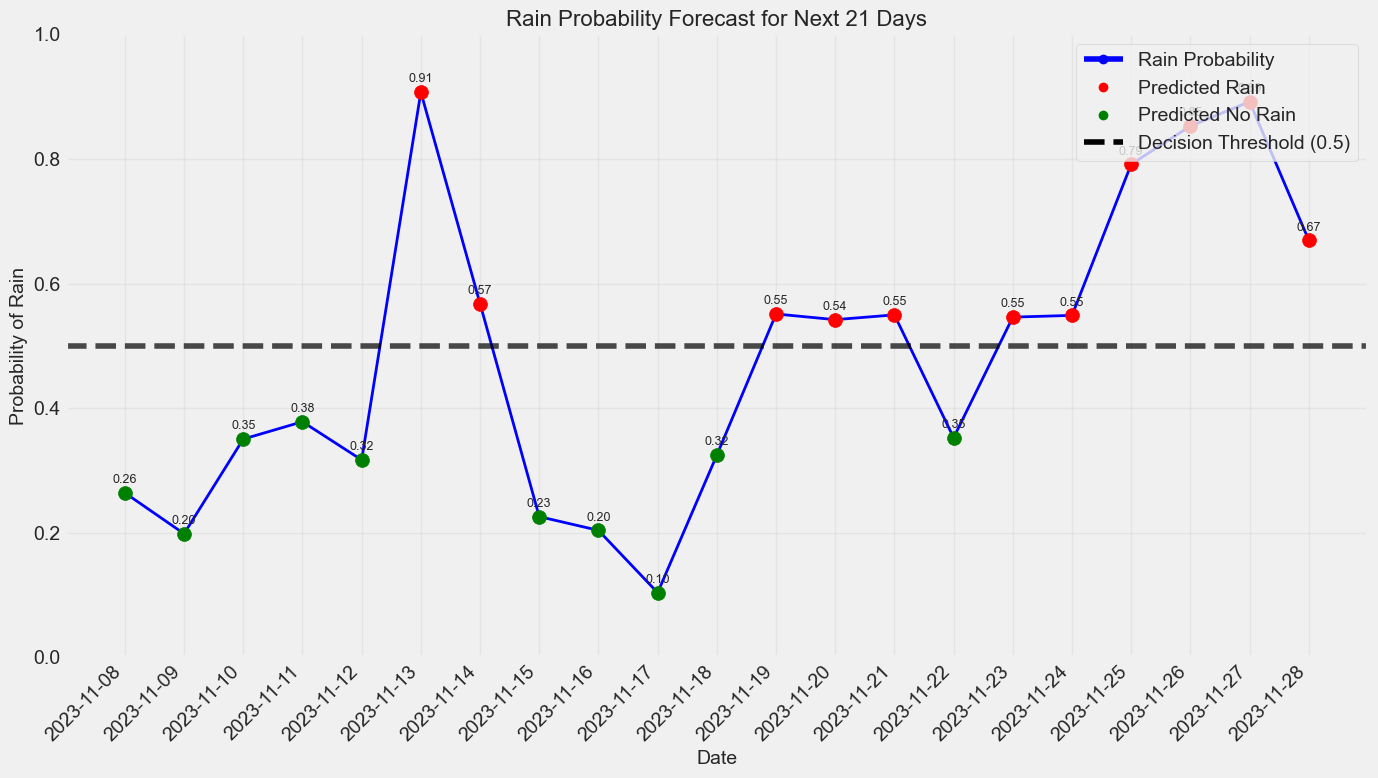

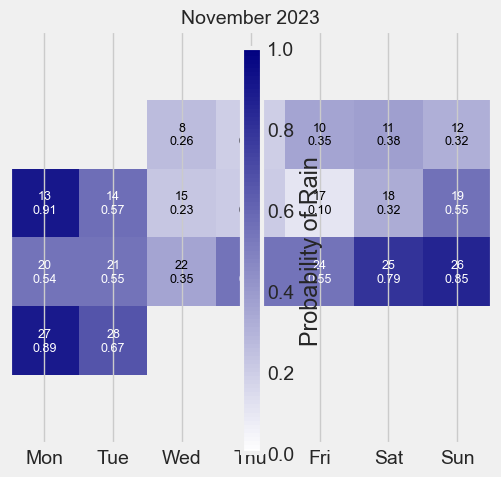


Forecast Summary:
- 11 out of 21 days are predicted to have rain (52.4%)
- Average rain probability: 0.48
- Maximum rain probability: 0.91 on 2023-11-13
- Minimum rain probability: 0.10 on 2023-11-17
- Longest predicted rain streak: 6 consecutive days
- Longest predicted no-rain streak: 5 consecutive days


In [31]:
# Get the last date in the dataset
last_date = df['date'].max()
print(f"Last date in dataset: {last_date}")

# Generate dates for the next 21 days
future_dates = [last_date + timedelta(days=i+1) for i in range(21)]

# Create a DataFrame for future predictions
future_df = pd.DataFrame({'date': future_dates})

# Extract date features
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day
future_df['day_of_week'] = future_df['date'].dt.dayofweek
future_df['day_of_year'] = future_df['date'].dt.dayofyear
future_df['is_weekend'] = future_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create cyclical features
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month']/12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month']/12)
future_df['day_of_week_sin'] = np.sin(2 * np.pi * future_df['day_of_week']/7)
future_df['day_of_week_cos'] = np.cos(2 * np.pi * future_df['day_of_week']/7)

# Create season feature
future_df['season'] = future_df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                           'Spring' if x in [3, 4, 5] else
                                           'Summer' if x in [6, 7, 8] else 'Fall')

# IMPORTANT FIX: Make sure we have the exact same season columns as in training data
# Instead of using pd.get_dummies, we'll manually create the columns
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    future_df[f'season_{season}'] = (future_df['season'] == season).astype(int)

# For numerical weather features, use moving averages from the last 30 days
last_30_days = df_clean.sort_values('date').tail(30)

# Calculate statistics for the weather features
weather_stats = {}
for feature in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:
    weather_stats[feature] = {
        'mean': last_30_days[feature].mean(),
        'std': last_30_days[feature].std(),
        'min': last_30_days[feature].min(),
        'max': last_30_days[feature].max(),
        'last': last_30_days[feature].iloc[-1],
        'last_7_mean': last_30_days[feature].tail(7).mean()
    }

# Initialize weather features with reasonable forecasted values
np.random.seed(42)  # For reproducibility

# Apply weather feature values (with seasonal trends and realistic variations)
for feature in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:
    # Use mean and seasonal trends with some realistic variation
    mean_val = weather_stats[feature]['mean']
    std_val = weather_stats[feature]['std']
    last_val = weather_stats[feature]['last']
    
    # Start with the last value and add variations for each day
    prev_val = last_val
    values = []
    
    for i in range(21):
        # Add some persistence (autocorrelation) and randomness
        # This simulates realistic day-to-day variations in weather patterns
        random_factor = np.random.normal(0, std_val * 0.3)  # Lower volatility for smoother predictions
        trend_factor = (mean_val - prev_val) * 0.1  # Slight reversion to the mean
        
        # Calculate new value with persistence
        new_val = prev_val + trend_factor + random_factor
        
        # Ensure the value stays within historical bounds
        new_val = max(min(new_val, weather_stats[feature]['max']), weather_stats[feature]['min'])
        
        values.append(new_val)
        prev_val = new_val
    
    future_df[feature] = values

# Create all the necessary features to match the training data
# Create interaction features
future_df['temp_humidity'] = future_df['avg_temperature'] * future_df['humidity']
future_df['temp_pressure'] = future_df['avg_temperature'] * future_df['pressure']
future_df['wind_cloud'] = future_df['avg_wind_speed'] * future_df['cloud_cover']
future_df['humidity_pressure'] = future_df['humidity'] * future_df['pressure']
future_df['wind_temp_ratio'] = future_df['avg_wind_speed'] / (future_df['avg_temperature'] + 1e-8)

# Initialize past_*day_rain_freq features based on historical data
# Get the rain patterns from the last part of the dataset
last_14_days_rain = df_features.sort_values('date').tail(14)['rain_binary'].values
future_df['past_3day_rain_freq'] = 0.0
future_df['past_7day_rain_freq'] = 0.0
future_df['past_14day_rain_freq'] = 0.0

# Start with historical values and update them as we make predictions
# First day uses last 3, 7, 14 days from historical data
future_df.loc[0, 'past_3day_rain_freq'] = np.mean(last_14_days_rain[-3:])
future_df.loc[0, 'past_7day_rain_freq'] = np.mean(last_14_days_rain[-7:])
future_df.loc[0, 'past_14day_rain_freq'] = np.mean(last_14_days_rain[-14:])

# For lag features of first few days, use historical data
for feature in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:
    # For first day
    # Get values from historical data
    historical_values = last_30_days[feature].values
    
    # Previous day
    future_df.loc[0, f'{feature}_lag1'] = historical_values[-1]
    # 3 days ago
    future_df.loc[0, f'{feature}_lag3'] = historical_values[-3] if len(historical_values) >= 3 else historical_values[-1]
    # 7 days ago
    future_df.loc[0, f'{feature}_lag7'] = historical_values[-7] if len(historical_values) >= 7 else historical_values[-1]
    
    # Calculate rolling window features for first day
    future_df.loc[0, f'{feature}_roll3'] = np.mean(historical_values[-3:])
    future_df.loc[0, f'{feature}_roll7'] = np.mean(historical_values[-7:])
    
    # Standard deviations
    future_df.loc[0, f'{feature}_std3'] = np.std(historical_values[-3:])
    future_df.loc[0, f'{feature}_std7'] = np.std(historical_values[-7:])
    
    # Change features
    future_df.loc[0, f'{feature}_change1'] = historical_values[-1] - historical_values[-2] if len(historical_values) >= 2 else 0
    future_df.loc[0, f'{feature}_change3'] = historical_values[-1] - historical_values[-4] if len(historical_values) >= 4 else 0
    
    # Trend features
    future_df.loc[0, f'{feature}_trend1'] = 1 if historical_values[-1] > historical_values[-2] else (-1 if historical_values[-1] < historical_values[-2] else 0)
    future_df.loc[0, f'{feature}_trend3'] = 1 if historical_values[-1] > historical_values[-4] else (-1 if historical_values[-1] < historical_values[-4] else 0)

# CRITICAL FIX: Ensure all features in the training data are also in the forecast data
# First, check which columns from X_train are missing in future_df
model_features_list = X_train.columns.tolist()
missing_columns = set(model_features_list) - set(future_df.columns)

print(f"Missing columns in forecast data: {missing_columns}")

# Add any missing columns with default values of 0
for col in missing_columns:
    future_df[col] = 0

# Now make predictions and update lag values recursively for remaining days
predictions = []
probabilities = []

# Make first prediction using the features we've set up
first_day_features = future_df.loc[0]
# Use only the features that the model was trained on
first_day_model_features = pd.DataFrame([first_day_features[model_features_list]])

# Scale the features
first_day_features_scaled = scaler.transform(first_day_model_features)

# Make prediction for first day
if best_tuned_result:
    first_prob = best_model.predict_proba(first_day_features_scaled)[0, 1]
else:
    first_prob = best_model_result['model'].predict_proba(first_day_features_scaled)[0, 1]
    
first_pred = 1 if first_prob >= 0.5 else 0

predictions.append(first_pred)
probabilities.append(first_prob)

# Now update features and predict for remaining days
for i in range(1, len(future_df)):
    # Update lag features based on previous days
    for feature in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:
        # Update lag1 (previous day)
        future_df.loc[i, f'{feature}_lag1'] = future_df.loc[i-1, feature]
        
        # Update lag3 (3 days ago)
        if i >= 3:
            future_df.loc[i, f'{feature}_lag3'] = future_df.loc[i-3, feature]
        else:
            idx = i-3
            if idx < 0 and abs(idx) <= len(historical_values):
                future_df.loc[i, f'{feature}_lag3'] = historical_values[idx]
            else:
                future_df.loc[i, f'{feature}_lag3'] = future_df.loc[0, feature]
        
        # Update lag7 (7 days ago)
        if i >= 7:
            future_df.loc[i, f'{feature}_lag7'] = future_df.loc[i-7, feature]
        else:
            idx = i-7
            if idx < 0 and abs(idx) <= len(historical_values):
                future_df.loc[i, f'{feature}_lag7'] = historical_values[idx]
            else:
                future_df.loc[i, f'{feature}_lag7'] = future_df.loc[0, feature]
        
        # Rolling window statistics - last 3 days
        if i >= 2:
            future_df.loc[i, f'{feature}_roll3'] = future_df.loc[i-2:i, feature].mean()
            future_df.loc[i, f'{feature}_std3'] = future_df.loc[i-2:i, feature].std()
        else:
            # Include historical values to fill the window
            values = []
            for j in range(3):
                if i-j >= 0:
                    values.append(future_df.loc[i-j, feature])
                elif abs(i-j) <= len(historical_values):
                    values.append(historical_values[i-j])
            
            future_df.loc[i, f'{feature}_roll3'] = np.mean(values)
            future_df.loc[i, f'{feature}_std3'] = np.std(values)
        
        # Rolling window statistics - last 7 days
        if i >= 6:
            future_df.loc[i, f'{feature}_roll7'] = future_df.loc[i-6:i, feature].mean()
            future_df.loc[i, f'{feature}_std7'] = future_df.loc[i-6:i, feature].std()
        else:
            # Include historical values to fill the window
            values = []
            for j in range(7):
                if i-j >= 0:
                    values.append(future_df.loc[i-j, feature])
                elif abs(i-j) <= len(historical_values):
                    values.append(historical_values[i-j])
            
            future_df.loc[i, f'{feature}_roll7'] = np.mean(values)
            future_df.loc[i, f'{feature}_std7'] = np.std(values)
        
        # Change features
        future_df.loc[i, f'{feature}_change1'] = future_df.loc[i, feature] - future_df.loc[i-1, feature]
        
        if i >= 3:
            future_df.loc[i, f'{feature}_change3'] = future_df.loc[i, feature] - future_df.loc[i-3, feature]
        else:
            idx = i-3
            if idx < 0 and abs(idx) <= len(historical_values):
                future_df.loc[i, f'{feature}_change3'] = future_df.loc[i, feature] - historical_values[idx]
            else:
                future_df.loc[i, f'{feature}_change3'] = 0
        
        # Trend features
        future_df.loc[i, f'{feature}_trend1'] = 1 if future_df.loc[i, feature] > future_df.loc[i-1, feature] else (-1 if future_df.loc[i, feature] < future_df.loc[i-1, feature] else 0)
        
        if i >= 3:
            future_df.loc[i, f'{feature}_trend3'] = 1 if future_df.loc[i, feature] > future_df.loc[i-3, feature] else (-1 if future_df.loc[i, feature] < future_df.loc[i-3, feature] else 0)
        else:
            future_df.loc[i, f'{feature}_trend3'] = 0
    
    # Update rain frequency features based on previous predictions
    # For past 3-day rain frequency
    if i < 3:
        # Use a mix of historical data and predictions
        historical_part = last_14_days_rain[-(3-i):] if i < 3 else []
        prediction_part = predictions[:i]
        all_values = list(historical_part) + prediction_part
        future_df.loc[i, 'past_3day_rain_freq'] = np.mean(all_values[-3:]) if all_values else 0
    else:
        future_df.loc[i, 'past_3day_rain_freq'] = np.mean(predictions[i-3:i])
    
    # For past 7-day rain frequency
    if i < 7:
        # Use a mix of historical data and predictions
        historical_part = last_14_days_rain[-(7-i):] if i < 7 else []
        prediction_part = predictions[:i]
        all_values = list(historical_part) + prediction_part
        future_df.loc[i, 'past_7day_rain_freq'] = np.mean(all_values[-7:]) if all_values else 0
    else:
        future_df.loc[i, 'past_7day_rain_freq'] = np.mean(predictions[i-7:i])
    
    # For past 14-day rain frequency
    if i < 14:
        # Use a mix of historical data and predictions
        historical_part = last_14_days_rain[-(14-i):] if i < 14 else []
        prediction_part = predictions[:i]
        all_values = list(historical_part) + prediction_part
        future_df.loc[i, 'past_14day_rain_freq'] = np.mean(all_values[-14:]) if all_values else 0
    else:
        future_df.loc[i, 'past_14day_rain_freq'] = np.mean(predictions[i-14:i])
    
    # Now make prediction for this day
    day_features = future_df.loc[i]
    # Use only the features that the model was trained on
    day_model_features = pd.DataFrame([day_features[model_features_list]])
    
    # Scale the features
    day_features_scaled = scaler.transform(day_model_features)
    
    # Make prediction
    if best_tuned_result:
        prob = best_model.predict_proba(day_features_scaled)[0, 1]
    else:
        prob = best_model_result['model'].predict_proba(day_features_scaled)[0, 1]
        
    pred = 1 if prob >= 0.5 else 0
    
    predictions.append(pred)
    probabilities.append(prob)

# Add predictions to the forecast dataframe
future_df['rain_probability'] = probabilities
future_df['rain_prediction'] = predictions
future_df['rain_prediction_label'] = future_df['rain_prediction'].map({1: 'Rain', 0: 'No Rain'})

# Display the final forecast
forecast_display = future_df[['date', 'rain_probability', 'rain_prediction_label']].copy()
forecast_display['date'] = forecast_display['date'].dt.strftime('%Y-%m-%d')
print("\nRain forecast for next 21 days:")
print(forecast_display.to_string(index=False))

# Save the forecast to CSV
forecast_display.to_csv('rain_forecast_next_21_days.csv', index=False)
print("\nForecast saved to 'rain_forecast_next_21_days.csv'")

# Visualize the forecast
plt.figure(figsize=(14, 8))

# Plot the probabilities as a line
plt.plot(range(len(future_df)), future_df['rain_probability'], marker='o', linestyle='-', linewidth=2, color='blue')

# Color the points based on the prediction
for i, (idx, row) in enumerate(future_df.iterrows()):
    if row['rain_prediction'] == 1:
        plt.scatter(i, row['rain_probability'], color='red', s=100, zorder=5)
    else:
        plt.scatter(i, row['rain_probability'], color='green', s=100, zorder=5)

# Add threshold line
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold (0.5)')

# Add labels and title
plt.title('Rain Probability Forecast for Next 21 Days', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Probability of Rain', fontsize=14)
plt.xticks(range(len(future_df)), future_df['date'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', marker='o', linestyle='-', label='Rain Probability'),
    Line2D([0], [0], marker='o', color='red', linestyle='', label='Predicted Rain'),
    Line2D([0], [0], marker='o', color='green', linestyle='', label='Predicted No Rain'),
    Line2D([0], [0], color='black', linestyle='--', label='Decision Threshold (0.5)')
]
plt.legend(handles=legend_elements, loc='upper right')

# Add annotations with probabilities
for i, (idx, row) in enumerate(future_df.iterrows()):
    plt.annotate(f"{row['rain_probability']:.2f}", 
                (i, row['rain_probability']),
                xytext=(0, 7), textcoords='offset points',
                ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('visualizations/rain_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a calendar-style visualization
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap from white to blue
cmap = LinearSegmentedColormap.from_list('white_to_blue', ['white', 'navy'], N=100)

# Extract month and date information
future_df['year'] = future_df['date'].dt.year
future_df['month_name'] = future_df['date'].dt.strftime('%B')
future_df['day_num'] = future_df['date'].dt.day

# Group by month
months = future_df['month_name'].unique()

# Calculate the number of rows and columns needed
n_months = len(months)
n_cols = min(3, n_months)
n_rows = (n_months + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))

for i, month in enumerate(months):
    month_data = future_df[future_df['month_name'] == month]
    
    # Create subplot
    ax = plt.subplot(n_rows, n_cols, i+1)
    
    # Get the first day of the month and its weekday (0=Monday, 6=Sunday)
    first_day = month_data['day_num'].min()
    first_weekday = month_data[month_data['day_num'] == first_day]['day_of_week'].values[0]
    
    # Create a calendar grid
    calendar_data = np.ones((6, 7)) * np.nan  # 6 weeks, 7 days per week
    
    # Fill the calendar with probability values
    for _, row in month_data.iterrows():
        day = row['day_num']
        weekday = row['day_of_week']
        week = (day + first_weekday - 1) // 7
        calendar_data[week, weekday] = row['rain_probability']
    
    # Plot the heatmap
    im = ax.imshow(calendar_data, cmap=cmap, vmin=0, vmax=1)
    
    # Add day numbers and probability values
    for week in range(6):
        for weekday in range(7):
            val = calendar_data[week, weekday]
            if not np.isnan(val):
                day_num = weekday - first_weekday + 1 + week * 7
                if 1 <= day_num <= 31:  # Valid day for the month
                    # Determine text color based on probability (white for high probabilities)
                    text_color = 'white' if val > 0.5 else 'black'
                    ax.text(weekday, week, f"{day_num}\n{val:.2f}", 
                            ha='center', va='center', color=text_color, fontsize=9)
    
    # Set title and labels
    ax.set_title(f'{month} {future_df["year"].iloc[0]}', fontsize=14)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax.set_yticks([])
    
plt.colorbar(im, ax=plt.gcf().get_axes(), label='Probability of Rain')
plt.tight_layout()
plt.savefig('visualizations/rain_calendar.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics for the forecast
rain_days = future_df[future_df['rain_prediction'] == 1]
print(f"\nForecast Summary:")
print(f"- {len(rain_days)} out of 21 days are predicted to have rain ({len(rain_days)/21*100:.1f}%)")
print(f"- Average rain probability: {future_df['rain_probability'].mean():.2f}")
print(f"- Maximum rain probability: {future_df['rain_probability'].max():.2f} on {future_df.loc[future_df['rain_probability'].idxmax(), 'date'].strftime('%Y-%m-%d')}")
print(f"- Minimum rain probability: {future_df['rain_probability'].min():.2f} on {future_df.loc[future_df['rain_probability'].idxmin(), 'date'].strftime('%Y-%m-%d')}")

# Consecutive rain/no rain days
rain_streaks = []
no_rain_streaks = []
current_streak = 1
current_type = predictions[0]

for i in range(1, len(predictions)):
    if predictions[i] == current_type:
        current_streak += 1
    else:
        if current_type == 1:
            rain_streaks.append(current_streak)
        else:
            no_rain_streaks.append(current_streak)
        current_streak = 1
        current_type = predictions[i]

# Add the last streak
if current_type == 1:
    rain_streaks.append(current_streak)
else:
    no_rain_streaks.append(current_streak)

print(f"- Longest predicted rain streak: {max(rain_streaks) if rain_streaks else 0} consecutive days")
print(f"- Longest predicted no-rain streak: {max(no_rain_streaks) if no_rain_streaks else 0} consecutive days")